**PREPARACION INICIAL DE LOS DATOS Y COMPROBACIÓN DE CARGA CORRECTA**


In [1]:
import pandas as pd

# 1. Cargar datasets
ruta_uber = "/content/df_procesado_uber.csv"
ruta_spy = "/content/df_spy_lstm.csv"

df_spy = pd.read_csv(ruta_spy, index_col=0, parse_dates=True)
df_uber = pd.read_csv(ruta_uber, index_col=0, parse_dates=True)

# 2. Limpiar nombres de columnas (eliminar espacios extra)
df_spy.columns = df_spy.columns.str.strip()
df_uber.columns = df_uber.columns.str.strip()

# 3. Convertir el índice en columna (si es necesario)
if "open" not in df_uber.columns:
    df_uber["open"] = df_uber.index  # Pasar índice a columna
    df_uber.reset_index(drop=True, inplace=True)  # Resetear índice


# 4. Eliminar variables que podrían sesgar el modelo
df_spy = df_spy.drop(columns=["volatility"], errors="ignore")
df_spy = df_spy.drop(columns=["open_UBER"], errors="ignore")
df_uber = df_uber.drop(columns=["open_SPY"], errors="ignore")

# 5. Filtrar columnas para que coincidan con SPY (quitando las extra de UBER)
columnas_comunes = [col for col in df_spy.columns if col in df_uber.columns]
df_uber = df_uber[columnas_comunes]  # Mantener solo las columnas que coinciden


# 5. Filtrar columnas para que coincidan con SPY (quitando las extra de UBER)
columnas_comunes = [col for col in df_uber.columns if col in df_spy.columns]
df_spy = df_spy[columnas_comunes]  # Mantener solo las columnas que coinciden

# 6. Comprobar que todo está bien alineado
print("Columnas finales SPY:", df_spy.columns.tolist())
print("Columnas finales UBER:", df_uber.columns.tolist())



x = len(df_spy.columns)
y = len(df_uber.columns)
print(x, y)

Columnas finales SPY: ['open', 'volume', 'News Sentiment', 'open_APPL', 'open_AMZN', 'open_AVGO', 'open_BRK.B', 'open_GOOGL', 'open_GOOG', 'open_META', 'open_MSFT', 'open_NVDA', 'RSI', 'ema_long', 'MACD', 'MACD_signal', 'bollinger_mid', 'bollinger_std', 'ATR', 'monthly_return']
Columnas finales UBER: ['open', 'volume', 'News Sentiment', 'open_APPL', 'open_AMZN', 'open_AVGO', 'open_BRK.B', 'open_GOOGL', 'open_GOOG', 'open_META', 'open_MSFT', 'open_NVDA', 'RSI', 'ema_long', 'MACD', 'MACD_signal', 'bollinger_mid', 'bollinger_std', 'ATR', 'monthly_return']
20 20


**DEFINICION INICIAL DE FUNCIONES Y CUESTIONES INICIALES**


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Función para normalizar datos
def normalizar_datos(df):
    scaler = MinMaxScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_norm, scaler

# Función para crear secuencias de datos
def crear_secuencias(datos, n_pasos):
    X, y = [], []
    for i in range(n_pasos, len(datos)):
        X.append(datos.iloc[i - n_pasos:i].values)
        y.append(datos.iloc[i]["open"])
    return np.array(X), np.array(y)

# Función para construir modelo LSTM con Masking para ignorar los ceros
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking

def construir_gru(n_pasos, n_features):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(n_pasos, n_features)),  # Ignorar valores 0
        GRU(50, return_sequences=True),  # Primera capa GRU
        Dropout(0.2),
        GRU(50, return_sequences=False),  # Segunda capa GRU
        Dropout(0.2),
        Dense(25, activation="relu"),  # Capa densa intermedia
        Dense(1)  # Capa de salida para predicción
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# Función para construir modelo LSTM con Masking para ignorar los ceros
def construir_lstm(n_pasos, n_features):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(n_pasos, n_features)),  # Ignorar valores 0
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


  # Crear el DataFrame vacío para almacenar las métricas
metricas = pd.DataFrame(columns=[
    'RMSE Sin TL',
    'RMSE Con TL',
    'RMSE Adj. Sin TL',
    'RMSE Adj. Con TL',
    'MAE Sin TL',
    'MAE Con TL',
    'R2 Sin TL',
    'R2 Con TL',
    'MAPE Sin TL',
    'MAPE Con TL',
    'Porcentaje Train Tesla',
    'Modelo (GRU / LSTM)','Años de datos',
    'Épocas modelo base',
    'Épocas fine-tuning',
    'Capas congeladas',
])

**PREDICCION BOOTSTRAP INTERVALS DEFINITION**

# **MODELO CON REGLAS ESTABLECIDAS DE HIPERPARÁMETROS**

Años de datos disponibles para Uber: 4.64
Usando modelo GRU (años de datos: 4.64 ≤ 5)
Épocas para modelo base: 47
Épocas para fine-tuning: 32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - loss: 0.0193
Epoch 2/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - loss: 0.0023
Epoch 3/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - loss: 0.0014
Epoch 4/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - loss: 0.0012
Epoch 5/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - loss: 9.9008e-04
Epoch 6/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - loss: 8.7585e-04
Epoch 7/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 8.9196e-04
Epoch 8/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - loss: 9.1401e-04
Epoch 9/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 7.0799e-04
Epoch 10/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - loss: 6.1047e-04
Epoch 11/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - loss: 7.2669e-04
Epoch 12/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 6.0946e-04
Epoch 13/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - loss: 5.6996e-04
Epoch 14/47
304/304 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - loss: 

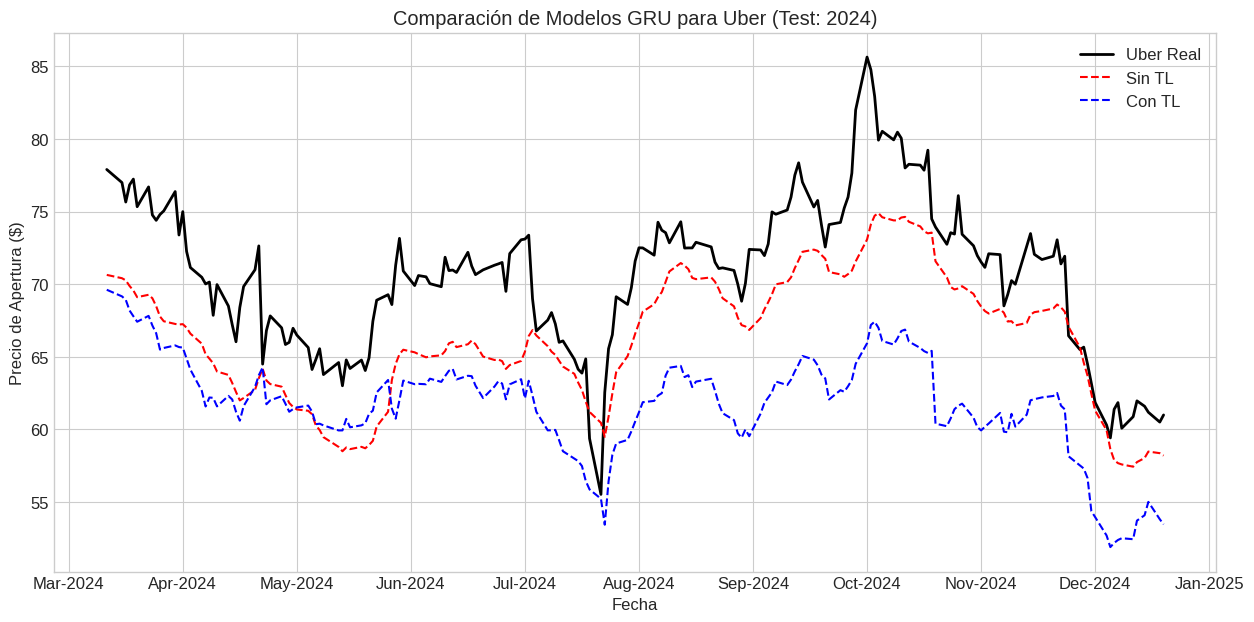


Comparación de métricas:
RMSE Sin TL: 4.94, Con TL: 9.46
RMSE Adj. Sin TL: 0.0699, Con TL: 0.1338
MAE Sin TL: 4.43, Con TL: 8.97
R2 Sin TL: 0.0972, Con TL: -2.3021
MAPE Sin TL: 6.19%, Con TL: 12.52%


<ipython-input-4-644bc3f7b0a4>:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metricas = pd.concat([metricas, pd.DataFrame({


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta

# 1. CONFIGURACIÓN DE PARÁMETROS
año_entrenamiento = 2023
n_pasos = 60

# 2. DIVISIÓN DEL CONJUNTO DE DATOS
df_spy_train = df_spy[:f'2019-05-10']
df_uber_train = df_uber['2019-05-10':f'{año_entrenamiento}-12-31']

año_prueba = año_entrenamiento + 1
df_uber_test = df_uber[f'{año_prueba}-01-01':f'{año_prueba}-12-31']

# Cálculo dinámico de años de datos disponibles para Uber
inicio_uber = pd.to_datetime('2019-05-10')
fin_entrenamiento = pd.to_datetime(f'{año_entrenamiento}-12-31')
años_de_datos = (fin_entrenamiento - inicio_uber).days / 365.25

print(f"Años de datos disponibles para Uber: {años_de_datos:.2f}")

# Selección dinámica del tipo de modelo
if años_de_datos <= 5:
    print(f"Usando modelo GRU (años de datos: {años_de_datos:.2f} ≤ 5)")
    construir_modelo = construir_gru
    tipo_modelo = "GRU"
else:
    print(f"Usando modelo LSTM (años de datos: {años_de_datos:.2f} > 5)")
    construir_modelo = construir_lstm
    tipo_modelo = "LSTM"

# Cálculo dinámico de épocas
epocas_modelo_base = max(10, int(50 - (años_de_datos / 2)))
epocas_fine_tuning = min(100, int(30 + (años_de_datos / 2)))

print(f"Épocas para modelo base: {epocas_modelo_base}")
print(f"Épocas para fine-tuning: {epocas_fine_tuning}")

# 3. NORMALIZACIÓN DE DATOS
scaler_spy = MinMaxScaler()
df_spy_train_norm = pd.DataFrame(scaler_spy.fit_transform(df_spy_train), columns=df_spy.columns, index=df_spy_train.index)

scaler_uber = MinMaxScaler()
df_uber_train_norm = pd.DataFrame(scaler_uber.fit_transform(df_uber_train), columns=df_uber.columns, index=df_uber_train.index)

df_uber_test_norm = pd.DataFrame(scaler_uber.transform(df_uber_test), columns=df_uber.columns, index=df_uber_test.index)

# 4. CREACIÓN DE SECUENCIAS DE DATOS PARA ENTRENAMIENTO
X_spy, y_spy = crear_secuencias(df_spy_train_norm, n_pasos)
X_uber, y_uber = crear_secuencias(df_uber_train_norm, n_pasos)

# 5. CONSTRUCCIÓN Y ENTRENAMIENTO DE MODELOS

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Modelo base SPY
modelo_spy = construir_modelo(n_pasos, X_spy.shape[2])
modelo_spy.fit(X_spy, y_spy, epochs=epocas_modelo_base, batch_size=16, verbose=1, callbacks=[early_stopping])

# Modelo Uber sin transfer learning
modelo_uber = construir_modelo(n_pasos, X_uber.shape[2])
modelo_uber.fit(X_uber, y_uber, epochs=50, batch_size=16, verbose=1, callbacks=[early_stopping])

# 6. TRANSFER LEARNING: AFINAR MODELO SPY CON UBER
modelo_spy_tuned = tf.keras.models.clone_model(modelo_spy)
modelo_spy_tuned.set_weights(modelo_spy.get_weights())

# Cálculo dinámico de capas a congelar
total_capas_entrenables = len([layer for layer in modelo_spy_tuned.layers if len(layer.weights) > 0])
capas_a_congelar = max(0, int(total_capas_entrenables - (años_de_datos / 2)))

print(f"Total de capas entrenables: {total_capas_entrenables}")
print(f"Capas a congelar: {capas_a_congelar}")

# Congelar capas según la fórmula
capas_congeladas = 0
for layer in modelo_spy_tuned.layers:
    if len(layer.weights) > 0:  # Solo considerar capas con pesos
        if capas_congeladas < capas_a_congelar:
            layer.trainable = False
            capas_congeladas += 1
            print(f"Capa {layer.name} congelada")
        else:
            layer.trainable = True
            print(f"Capa {layer.name} entrenable")

modelo_spy_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse")
modelo_spy_tuned.fit(X_uber, y_uber, epochs=epocas_fine_tuning, batch_size=16, verbose=1, callbacks=[early_stopping])

# 7. PREDICCIONES EN DATOS DE TEST
X_test, y_test = crear_secuencias(df_uber_test_norm, n_pasos)

pred_sin_tl = modelo_uber.predict(X_test)
pred_con_tl = modelo_spy_tuned.predict(X_test)

# 8. DESNORMALIZACIÓN DE PREDICCIONES
y_test_real = scaler_uber.inverse_transform(
    np.hstack([y_test.reshape(-1, 1)] + [np.zeros((y_test.shape[0], df_uber.shape[1] - 1))])
)[:, df_uber.columns.get_loc("open")]

pred_sin_tl_real = scaler_uber.inverse_transform(
    np.hstack([pred_sin_tl] + [np.zeros((pred_sin_tl.shape[0], df_uber.shape[1] - 1))])
)[:, df_uber.columns.get_loc("open")]

pred_con_tl_real = scaler_uber.inverse_transform(
    np.hstack([pred_con_tl] + [np.zeros((pred_con_tl.shape[0], df_uber.shape[1] - 1))])
)[:, df_uber.columns.get_loc("open")]

# 9. CÁLCULO DE MÉTRICAS DE ERROR
rmse_sin_tl = np.sqrt(mean_squared_error(y_test_real, pred_sin_tl_real))
rmse_con_tl = np.sqrt(mean_squared_error(y_test_real, pred_con_tl_real))

rmse_adj_sin_tl = rmse_sin_tl / np.average(y_test_real)
rmse_adj_con_tl = rmse_con_tl / np.average(y_test_real)

mae_sin_tl = mean_absolute_error(y_test_real, pred_sin_tl_real)
mae_con_tl = mean_absolute_error(y_test_real, pred_con_tl_real)

r2_sin_tl = r2_score(y_test_real, pred_sin_tl_real)
r2_con_tl = r2_score(y_test_real, pred_con_tl_real)

mape_sin_tl = np.mean(np.abs((y_test_real - pred_sin_tl_real) / y_test_real)) * 100
mape_con_tl = np.mean(np.abs((y_test_real - pred_con_tl_real) / y_test_real)) * 100

# 10. GRÁFICO DE COMPARACIÓN DE MODELOS
plt.figure(figsize=(15, 7))
plt.plot(df_uber_test.iloc[n_pasos:].index, y_test_real, label="Uber Real", color="black", linewidth=2)
plt.plot(df_uber_test.iloc[n_pasos:].index, pred_sin_tl_real, label="Sin TL", color="red", linestyle="dashed")
plt.plot(df_uber_test.iloc[n_pasos:].index, pred_con_tl_real, label="Con TL", color="blue", linestyle="dashed")
plt.title(f"Comparación de Modelos {tipo_modelo} para Uber (Test: {año_entrenamiento+1})")
plt.xlabel("Fecha")
plt.ylabel("Precio de Apertura ($)")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%b-%Y"))
plt.legend()
plt.grid(True)
plt.show()

# 11. ALMACENAR MÉTRICAS EN UN DATAFRAME
porcentaje_train_uber = len(df_uber_train) / len(df_uber) * 100

metricas = pd.concat([metricas, pd.DataFrame({
    'RMSE Sin TL': [rmse_sin_tl],
    'RMSE Con TL': [rmse_con_tl],
    'RMSE Adj. Sin TL': [rmse_adj_sin_tl],
    'RMSE Adj. Con TL': [rmse_adj_con_tl],
    'MAE Sin TL': [mae_sin_tl],
    'MAE Con TL': [mae_con_tl],
    'R2 Sin TL': [r2_sin_tl],
    'R2 Con TL': [r2_con_tl],
    'MAPE Sin TL': [mape_sin_tl],
    'MAPE Con TL': [mape_con_tl],
    'Porcentaje Train Uber': [porcentaje_train_uber],
    'Modelo (GRU / LSTM)': [tipo_modelo],
    'Años de datos': [años_de_datos],
    'Épocas modelo base': [epocas_modelo_base],
    'Épocas fine-tuning': [epocas_fine_tuning],
    'Capas congeladas': [capas_a_congelar]
}, index=[f'Año {año_entrenamiento}+{1}'])], ignore_index=False)

# Mostrar las métricas
print("\nComparación de métricas:")
print(f"RMSE Sin TL: {rmse_sin_tl:.2f}, Con TL: {rmse_con_tl:.2f}")
print(f"RMSE Adj. Sin TL: {rmse_adj_sin_tl:.4f}, Con TL: {rmse_adj_con_tl:.4f}")
print(f"MAE Sin TL: {mae_sin_tl:.2f}, Con TL: {mae_con_tl:.2f}")
print(f"R2 Sin TL: {r2_sin_tl:.4f}, Con TL: {r2_con_tl:.4f}")
print(f"MAPE Sin TL: {mape_sin_tl:.2f}%, Con TL: {mape_con_tl:.2f}%")

# Análisis de Volatilidad


<ipython-input-7-2a57a360defa>:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df_uber.resample('Y').agg({'ATR': 'mean'})


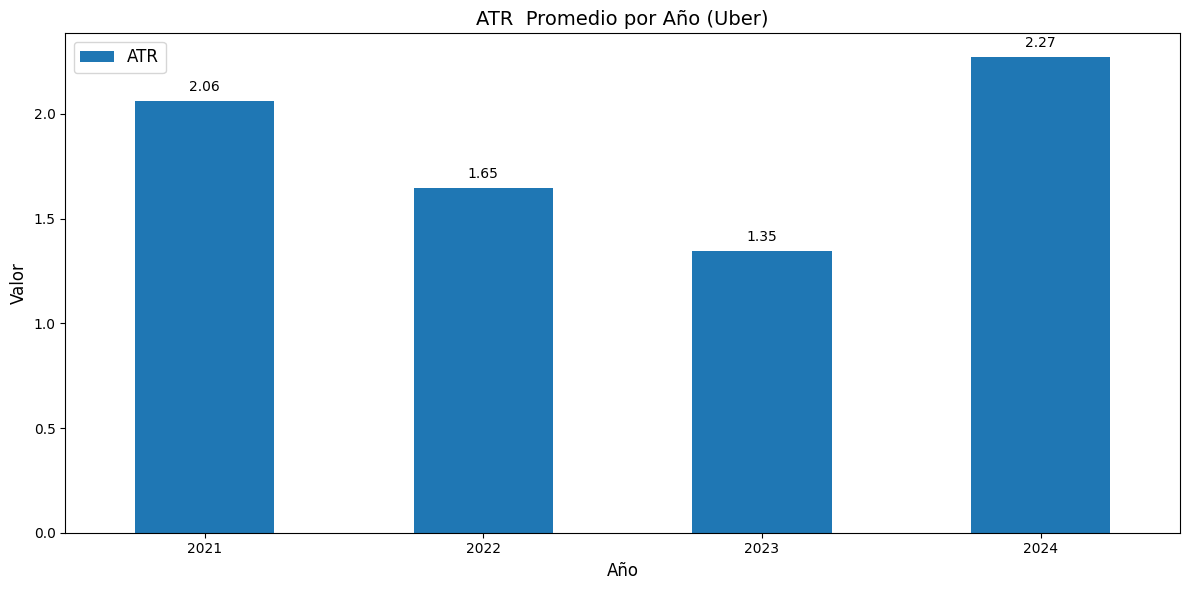

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Resampleo por año y calculo el ATR y la volatilidad promedio
df_yearly = df_uber.resample('Y').agg({'ATR': 'mean'})

# Filtrar para eliminar los años 2019 y 2020
df_yearly = df_yearly[~df_yearly.index.year.isin([2019, 2020])]

# Convertir el índice a solo el año
df_yearly.index = df_yearly.index.year

# Graficar ATR y volatilidad promedio por año
plt.figure(figsize=(12, 6))
ax = df_yearly[['ATR']].plot(kind='bar', ax=plt.gca())

# Mejoras en el gráfico
plt.title('ATR  Promedio por Año (Uber)', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=0)  # Asegurarse de que las etiquetas estén solo con el año
plt.legend(['ATR'], fontsize=12)

# Añadir las etiquetas en la parte superior de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=10)

# Ajuste de la estética
plt.tight_layout()
plt.show()

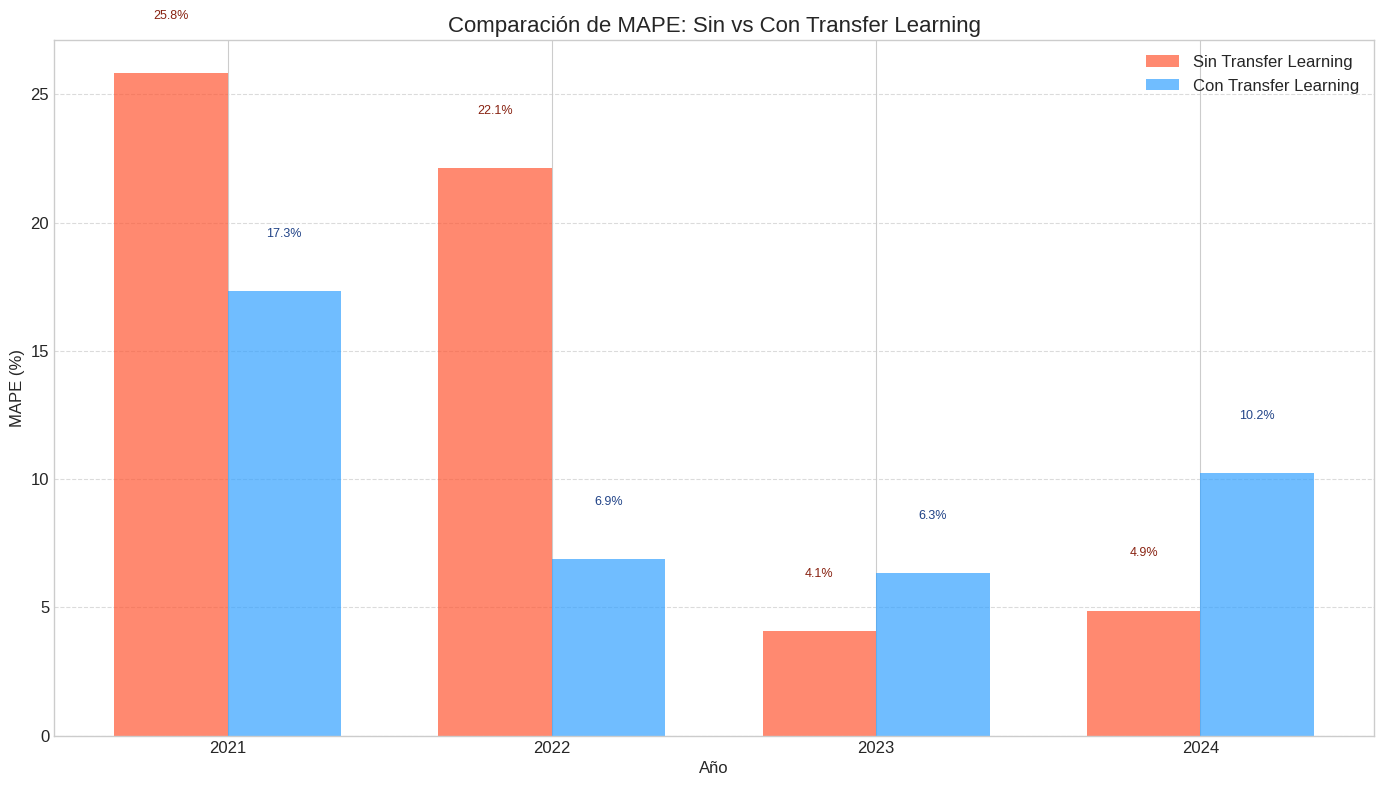

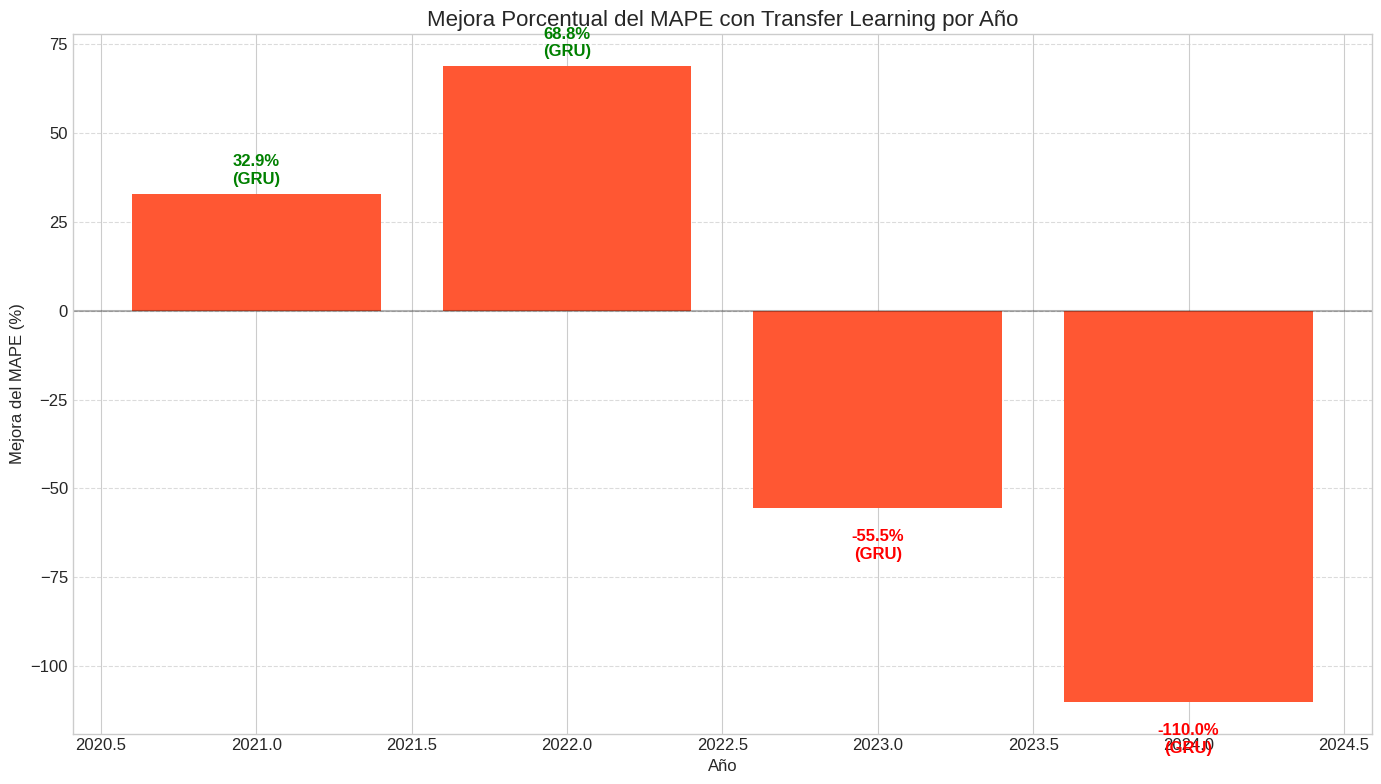

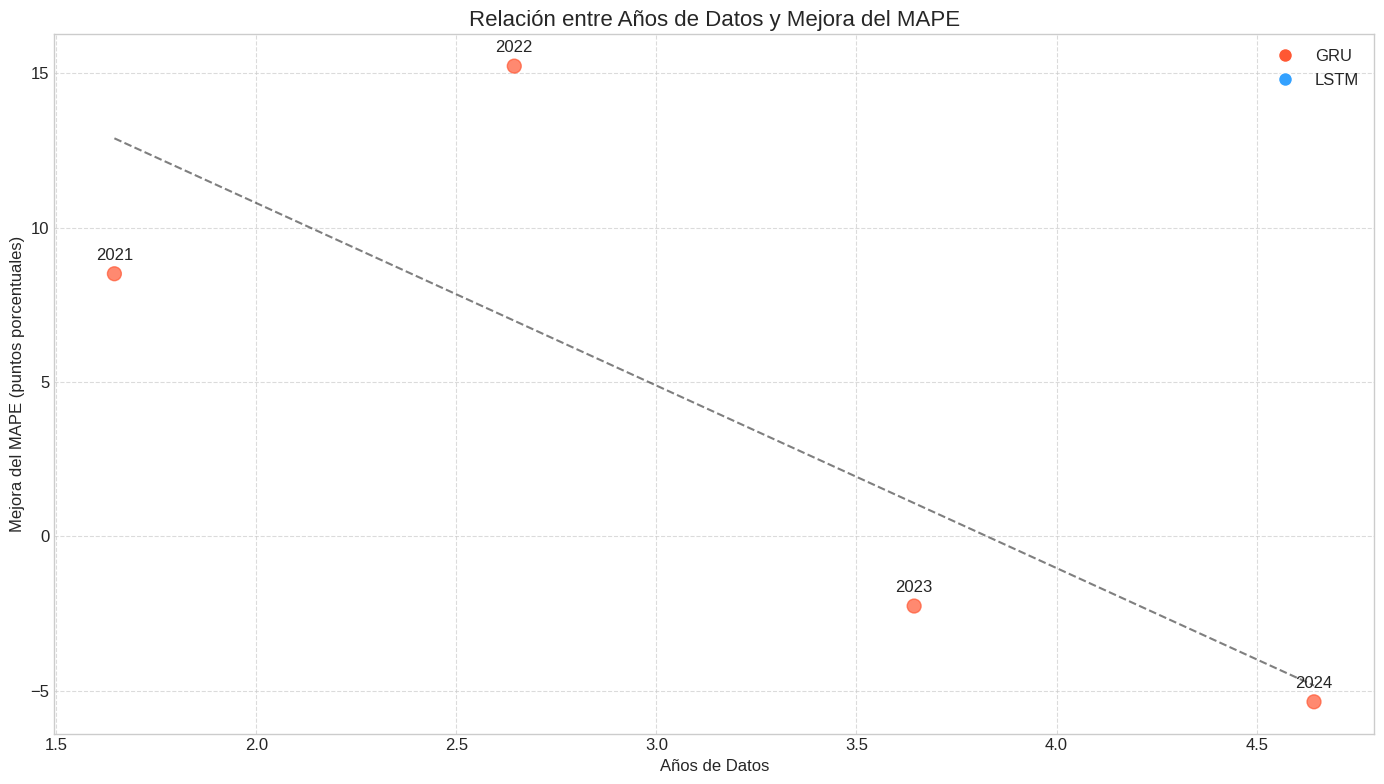

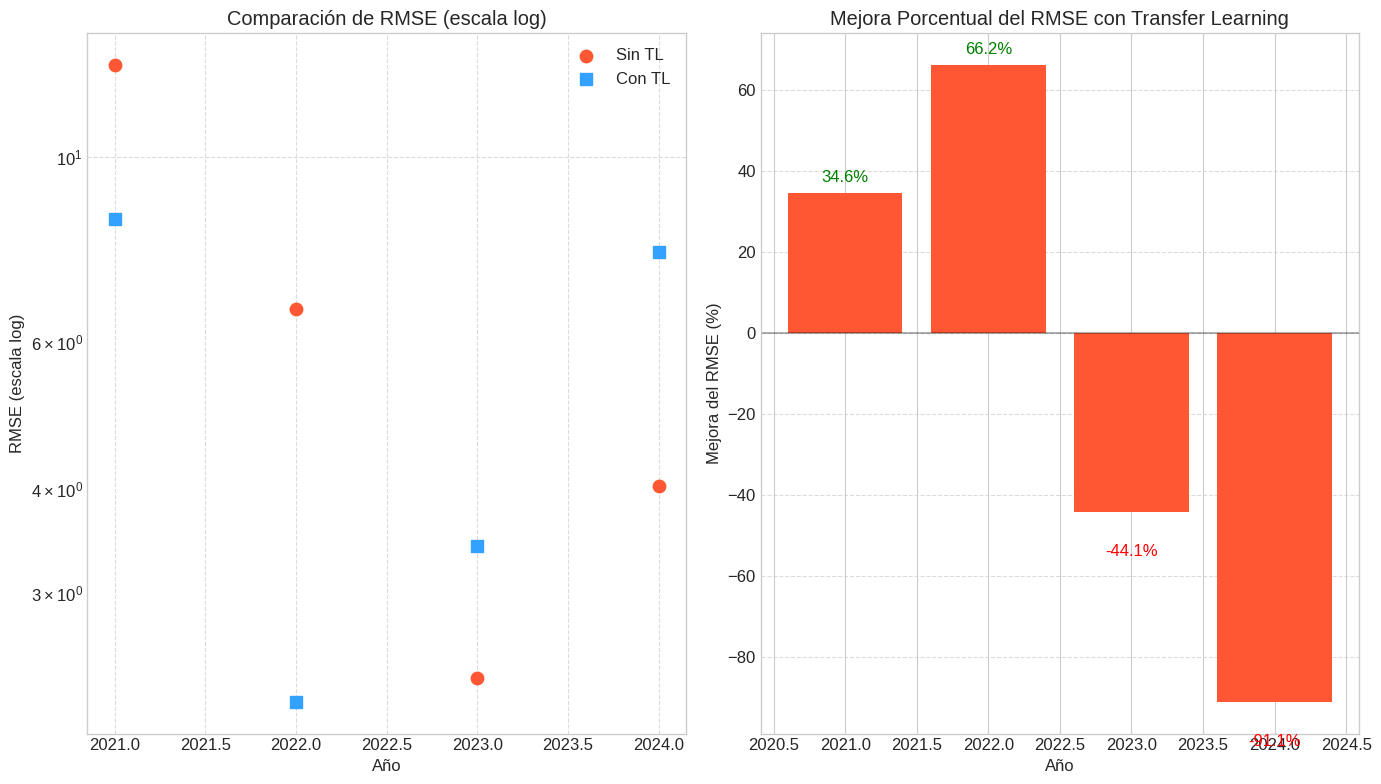

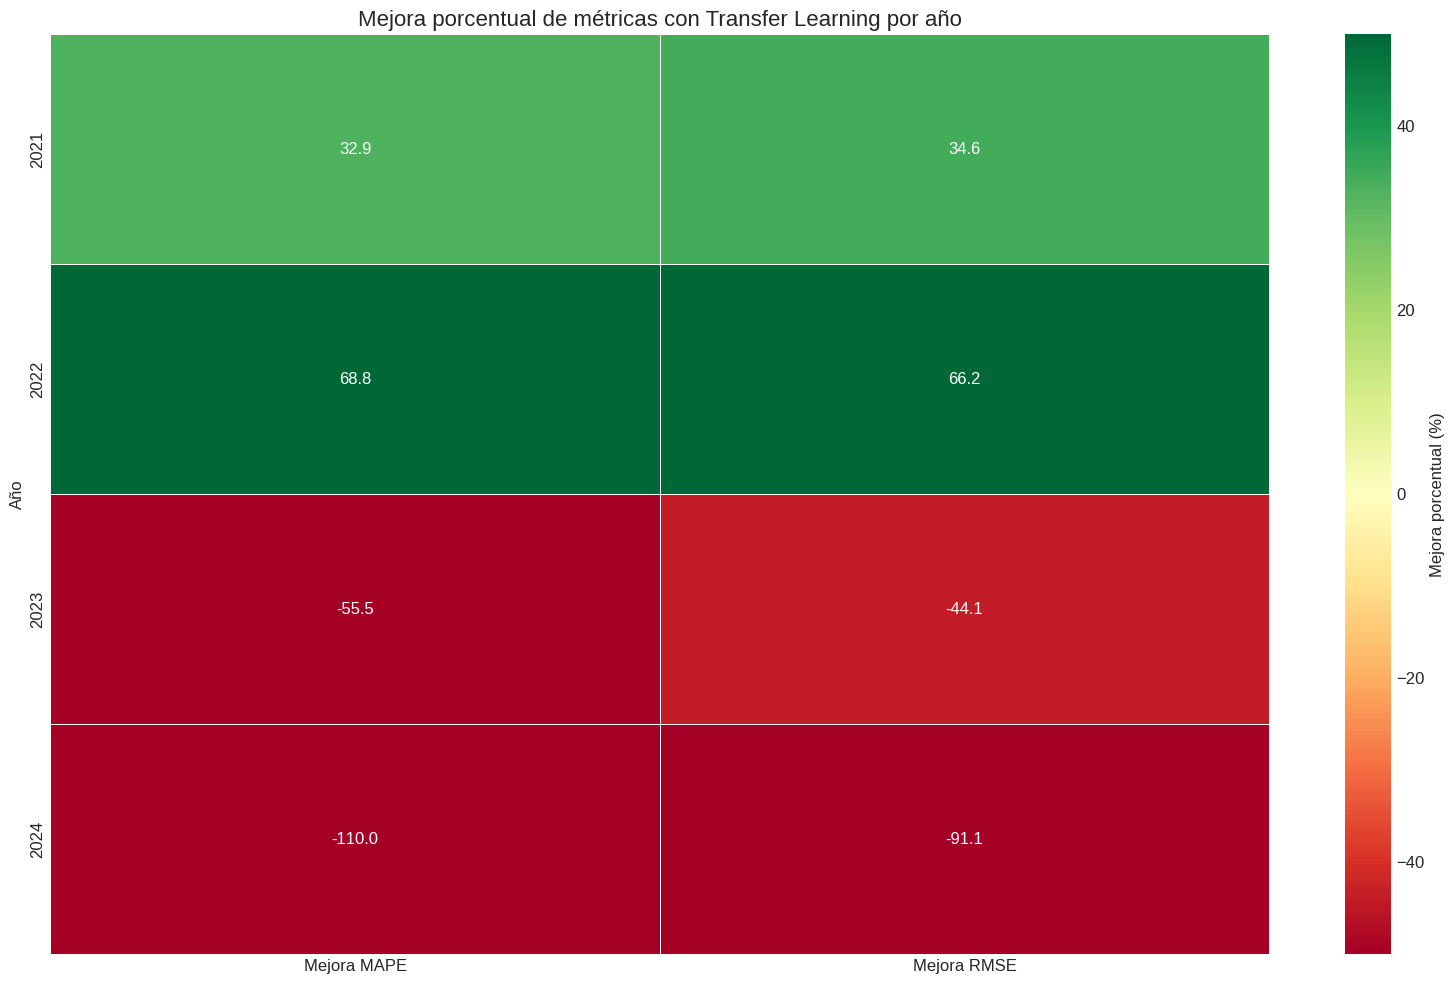

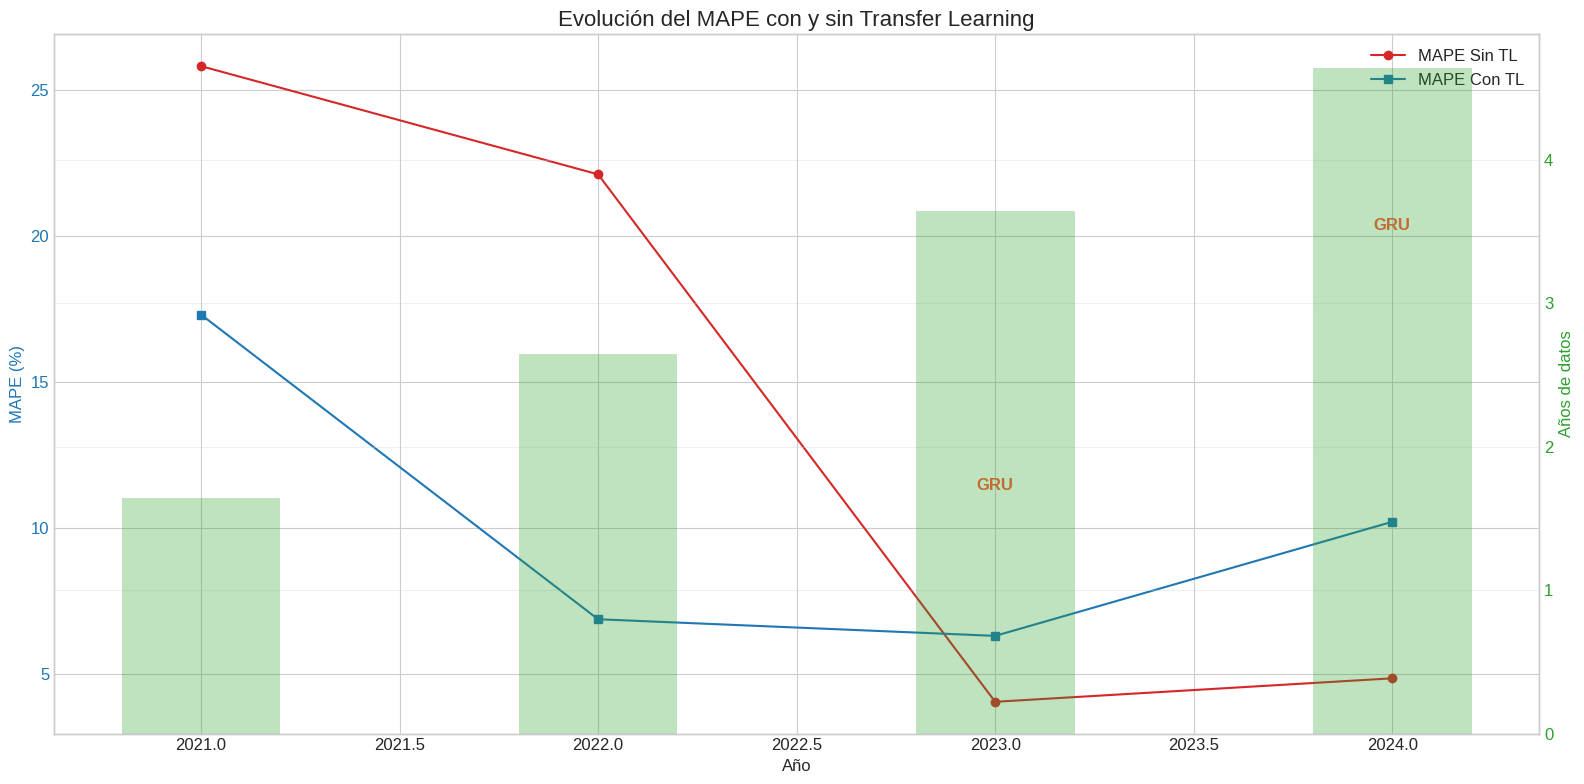

Resumen de mejoras con Transfer Learning:
Mejora media del MAPE: 4.03 puntos porcentuales
Mejora porcentual media del MAPE: -15.94%
Número de años con mejora en MAPE: 2 de 4
Mejora media del RMSE: 1.02
Mejora porcentual media del RMSE: -8.61%
Número de años con mejora en RMSE: 2 de 4

Comparación por tipo de modelo:
        Mejora MAPE %  Mejora RMSE %
Modelo                              
GRU        -15.944308      -8.613723


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el diccionario de datos
data = {
    'Año': [2021, 2022, 2023, 2024],
    'RMSE Sin TL': [12.893126, 6.568495, 2.372429, 4.027238],
    'RMSE Con TL': [8.435649, 2.221471, 3.419128, 7.695569],
    'RMSE Adj. Sin TL': [0.277584, 0.240618, 0.052982, 0.056957],
    'RMSE Adj. Con TL': [0.181616, 0.081377, 0.076357, 0.108839],
    'MAE Sin TL': [11.112561, 5.923569, 1.950498, 3.513193],
    'MAE Con TL': [7.516391, 1.806991, 2.950753, 7.334814],
    'R2 Sin TL': [-4.119358, -1.999043, 0.913372, 0.401186],
    'R2 Con TL': [-1.191473, 0.65697, 0.82007, -1.186547],
    'MAPE Sin TL': [25.823583, 22.119155, 4.06483, 4.868615],
    'MAPE Con TL': [17.319386, 6.89098, 6.321312, 10.22618],
    'Modelo': ['GRU', 'GRU', 'GRU', 'GRU'],
    'Años de datos': [1.645448, 2.644764, 3.644079, 4.643395],
    'Épocas modelo base': [49, 48, 48, 47],
    'Épocas fine-tuning': [30, 31, 31, 32],
    'Capas congeladas': [3, 2, 2, 1],
    'Porcentaje Train Uber': [29.275158, 47.009148, 64.672766, 82.26601]
}



# Crear el DataFrame
metricas = pd.DataFrame(data)

# Calcular la diferencia de MAPE (mejora)
metricas['Mejora MAPE'] = metricas['MAPE Sin TL'] - metricas['MAPE Con TL']
metricas['Mejora MAPE %'] = (metricas['Mejora MAPE'] / metricas['MAPE Sin TL']) * 100
metricas['Mejora RMSE'] = metricas['RMSE Sin TL'] - metricas['RMSE Con TL']
metricas['Mejora RMSE %'] = (metricas['Mejora RMSE'] / metricas['RMSE Sin TL']) * 100

# Configuración estética para los gráficos
plt.style.use('seaborn-v0_8-whitegrid')
colors = {'GRU': '#FF5733', 'LSTM': '#33A1FF'}
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# 1. Gráfico de comparación de MAPE (Sin TL vs Con TL)
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(metricas['Año']))

plt.bar(index, metricas['MAPE Sin TL'], bar_width, label='Sin Transfer Learning', color='#FF5733', alpha=0.7)
plt.bar(index + bar_width, metricas['MAPE Con TL'], bar_width, label='Con Transfer Learning', color='#33A1FF', alpha=0.7)

plt.xlabel('Año')
plt.ylabel('MAPE (%)')
plt.title('Comparación de MAPE: Sin vs Con Transfer Learning', fontsize=16)
plt.xticks(index + bar_width/2, metricas['Año'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v1, v2 in zip(index, metricas['MAPE Sin TL'], metricas['MAPE Con TL']):
    if v1 > v2:
        plt.text(i, v1+2, f"{v1:.1f}%", ha='center', va='bottom', fontsize=9, color='#882211')
        plt.text(i + bar_width, v2+2, f"{v2:.1f}%", ha='center', va='bottom', fontsize=9, color='#224488')
    else:
        plt.text(i, v1+2, f"{v1:.1f}%", ha='center', va='bottom', fontsize=9, color='#882211')
        plt.text(i + bar_width, v2+2, f"{v2:.1f}%", ha='center', va='bottom', fontsize=9, color='#224488')

plt.tight_layout()
plt.show()

# 2. Gráfico de mejora porcentual del MAPE por año
plt.figure(figsize=(14, 8))
bars = plt.bar(metricas['Año'], metricas['Mejora MAPE %'], color=[colors[modelo] for modelo in metricas['Modelo']])

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Año')
plt.ylabel('Mejora del MAPE (%)')
plt.title('Mejora Porcentual del MAPE con Transfer Learning por Año', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir valores y colores según el tipo de modelo
for bar, year, value, modelo in zip(bars, metricas['Año'], metricas['Mejora MAPE %'], metricas['Modelo']):
    color = 'green' if value > 0 else 'red'
    plt.text(bar.get_x() + bar.get_width()/2,
             value + (2 if value > 0 else -6),
             f"{value:.1f}%\n({modelo})",
             ha='center', va='bottom' if value > 0 else 'top',
             color=color, fontweight='bold')

plt.tight_layout()
plt.show()

# 3. Gráfico de dispersión: Mejora MAPE vs Años de datos
plt.figure(figsize=(14, 8))
scatter = plt.scatter(metricas['Años de datos'],
                      metricas['Mejora MAPE'],
                      c=[colors[m] for m in metricas['Modelo']],
                      s=100,
                      alpha=0.7)

plt.xlabel('Años de Datos')
plt.ylabel('Mejora del MAPE (puntos porcentuales)')
plt.title('Relación entre Años de Datos y Mejora del MAPE', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Añadir línea de tendencia
z = np.polyfit(metricas['Años de datos'], metricas['Mejora MAPE'], 1)
p = np.poly1d(z)
plt.plot(metricas['Años de datos'], p(metricas['Años de datos']), "k--", alpha=0.5)

# Añadir etiquetas de año
for x, y, año in zip(metricas['Años de datos'], metricas['Mejora MAPE'], metricas['Año']):
    plt.annotate(str(año), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Crear leyenda para los modelos
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['GRU'], markersize=10, label='GRU'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['LSTM'], markersize=10, label='LSTM')]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# 4. Gráfico de RMSE comparativo
plt.figure(figsize=(14, 8))

# Usar escala logarítmica para RMSE debido a la gran variación
plt.subplot(1, 2, 1)
plt.scatter(metricas['Año'], metricas['RMSE Sin TL'], label='Sin TL', color='#FF5733', s=80, marker='o')
plt.scatter(metricas['Año'], metricas['RMSE Con TL'], label='Con TL', color='#33A1FF', s=80, marker='s')
plt.yscale('log')
plt.xlabel('Año')
plt.ylabel('RMSE (escala log)')
plt.title('Comparación de RMSE (escala log)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Mejora porcentual de RMSE
plt.subplot(1, 2, 2)
bars = plt.bar(metricas['Año'], metricas['Mejora RMSE %'], color=[colors[modelo] for modelo in metricas['Modelo']])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Año')
plt.ylabel('Mejora del RMSE (%)')
plt.title('Mejora Porcentual del RMSE con Transfer Learning')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, value in zip(bars, metricas['Mejora RMSE %']):
    color = 'green' if value > 0 else 'red'
    plt.text(bar.get_x() + bar.get_width()/2,
             value + (2 if value > 0 else -8),
             f"{value:.1f}%",
             ha='center', va='bottom' if value > 0 else 'top',
             color=color)

plt.tight_layout()
plt.show()

# 5. Heatmap de la mejora por año y tipo de métrica
plt.figure(figsize=(16, 10))

# Preparar datos para el heatmap
heatmap_data = metricas[['Año', 'Mejora MAPE %', 'Mejora RMSE %']]
heatmap_data = heatmap_data.set_index('Año')
heatmap_data.columns = ['Mejora MAPE', 'Mejora RMSE']

# Crear un mapa de calor
ax = sns.heatmap(heatmap_data,
                cmap="RdYlGn",
                annot=True,
                fmt=".1f",
                linewidths=.5,
                center=0,
                vmin=-50,
                vmax=50,
                cbar_kws={'label': 'Mejora porcentual (%)'})

plt.title('Mejora porcentual de métricas con Transfer Learning por año', fontsize=16)
plt.tight_layout()
plt.show()

# 6. Gráfico de resumen de MAPE y modelo usado
fig, ax1 = plt.subplots(figsize=(16, 8))

# MAPE comparativo
ax1.set_xlabel('Año')
ax1.set_ylabel('MAPE (%)', color='tab:blue')
ax1.plot(metricas['Año'], metricas['MAPE Sin TL'], 'o-', color='tab:red', label='MAPE Sin TL')
ax1.plot(metricas['Año'], metricas['MAPE Con TL'], 's-', color='tab:blue', label='MAPE Con TL')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Añadir información del modelo usado
for i, (year, mape_sin, mape_con, modelo) in enumerate(zip(metricas['Año'],
                                                         metricas['MAPE Sin TL'],
                                                         metricas['MAPE Con TL'],
                                                         metricas['Modelo'])):
    # Posicionar las etiquetas alternando arriba y abajo para claridad
    y_pos = max(mape_sin, mape_con) + (5 if i % 2 == 0 else 10)
    ax1.annotate(f"{modelo}", (year, y_pos),
                 color=colors[modelo],
                 weight='bold',
                 ha='center')

# Añadir años de datos en un eje secundario
ax2 = ax1.twinx()
ax2.set_ylabel('Años de datos', color='tab:green')
ax2.bar(metricas['Año'], metricas['Años de datos'], alpha=0.3, color='tab:green', width=0.4)
ax2.tick_params(axis='y', labelcolor='tab:green')

# Añadir línea de separación GRU/LSTM
cambio_modelo_idx = metricas[metricas['Modelo'] == 'LSTM'].index.min()
if pd.notna(cambio_modelo_idx):
    año_cambio = metricas.loc[cambio_modelo_idx, 'Año']
    plt.axvline(x=año_cambio - 0.5, color='black', linestyle='--', alpha=0.5)
    plt.text(año_cambio - 0.5, plt.ylim()[1] * 0.9, 'Cambio a LSTM',
             rotation=90, va='top', ha='right', alpha=0.7)

ax1.legend(loc='upper right')
plt.title('Evolución del MAPE con y sin Transfer Learning', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Estadísticas de resumen
print("Resumen de mejoras con Transfer Learning:")
print(f"Mejora media del MAPE: {metricas['Mejora MAPE'].mean():.2f} puntos porcentuales")
print(f"Mejora porcentual media del MAPE: {metricas['Mejora MAPE %'].mean():.2f}%")
print(f"Número de años con mejora en MAPE: {(metricas['Mejora MAPE'] > 0).sum()} de {len(metricas)}")
print(f"Mejora media del RMSE: {metricas['Mejora RMSE'].mean():.2f}")
print(f"Mejora porcentual media del RMSE: {metricas['Mejora RMSE %'].mean():.2f}%")
print(f"Número de años con mejora en RMSE: {(metricas['Mejora RMSE'] > 0).sum()} de {len(metricas)}")

# Análisis por tipo de modelo
print("\nComparación por tipo de modelo:")
print(metricas.groupby('Modelo')[['Mejora MAPE %', 'Mejora RMSE %']].mean())

# **ANÁLISIS DE MÉTRICAS**

In [ ]:
metricas

,RMSE Sin TL,RMSE Con TL,RMSE Adj. Sin TL,RMSE Adj. Con TL,MAE Sin TL,MAE Con TL,R2 Sin TL,R2 Con TL,MAPE Sin TL,MAPE Con TL,Porcentaje Train Tesla,Mejora RMSE,Mejora RMSE Adj,Mejora MAE,Mejora MAPE
Año 2011+1,1.660616,1.062683,0.802468,0.513526,1.583507,0.950380,-110.455667,-44.642714,77.071317,47.280151,10.460022,36.006678,36.006678,39.982548,38.654026
Año 2015+1,2.500892,1.338057,0.175221,0.093749,2.283457,1.293545,-3.040660,-0.156676,16.263141,9.191287,38.006572,46.496800,46.496800,43.351491,43.483937
Año 2020+1,31.605249,41.623220,0.120475,0.158662,22.795513,31.223867,0.710747,0.498316,7.756125,11.110842,72.480832,-31.697173,-31.697173,-36.973743,-43.252498
Año 2023+1,38.811052,42.741147,0.160797,0.177080,31.754051,28.418278,0.747611,0.693908,12.447812,9.692730,93.099671,-10.126225,-10.126225,10.505030,22.133062


In [ ]:

# Apply round function to all numeric columns in the 'metricas' DataFrame
metricas = metricas.round(2)


<ipython-input-41-f3769095b60a>:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


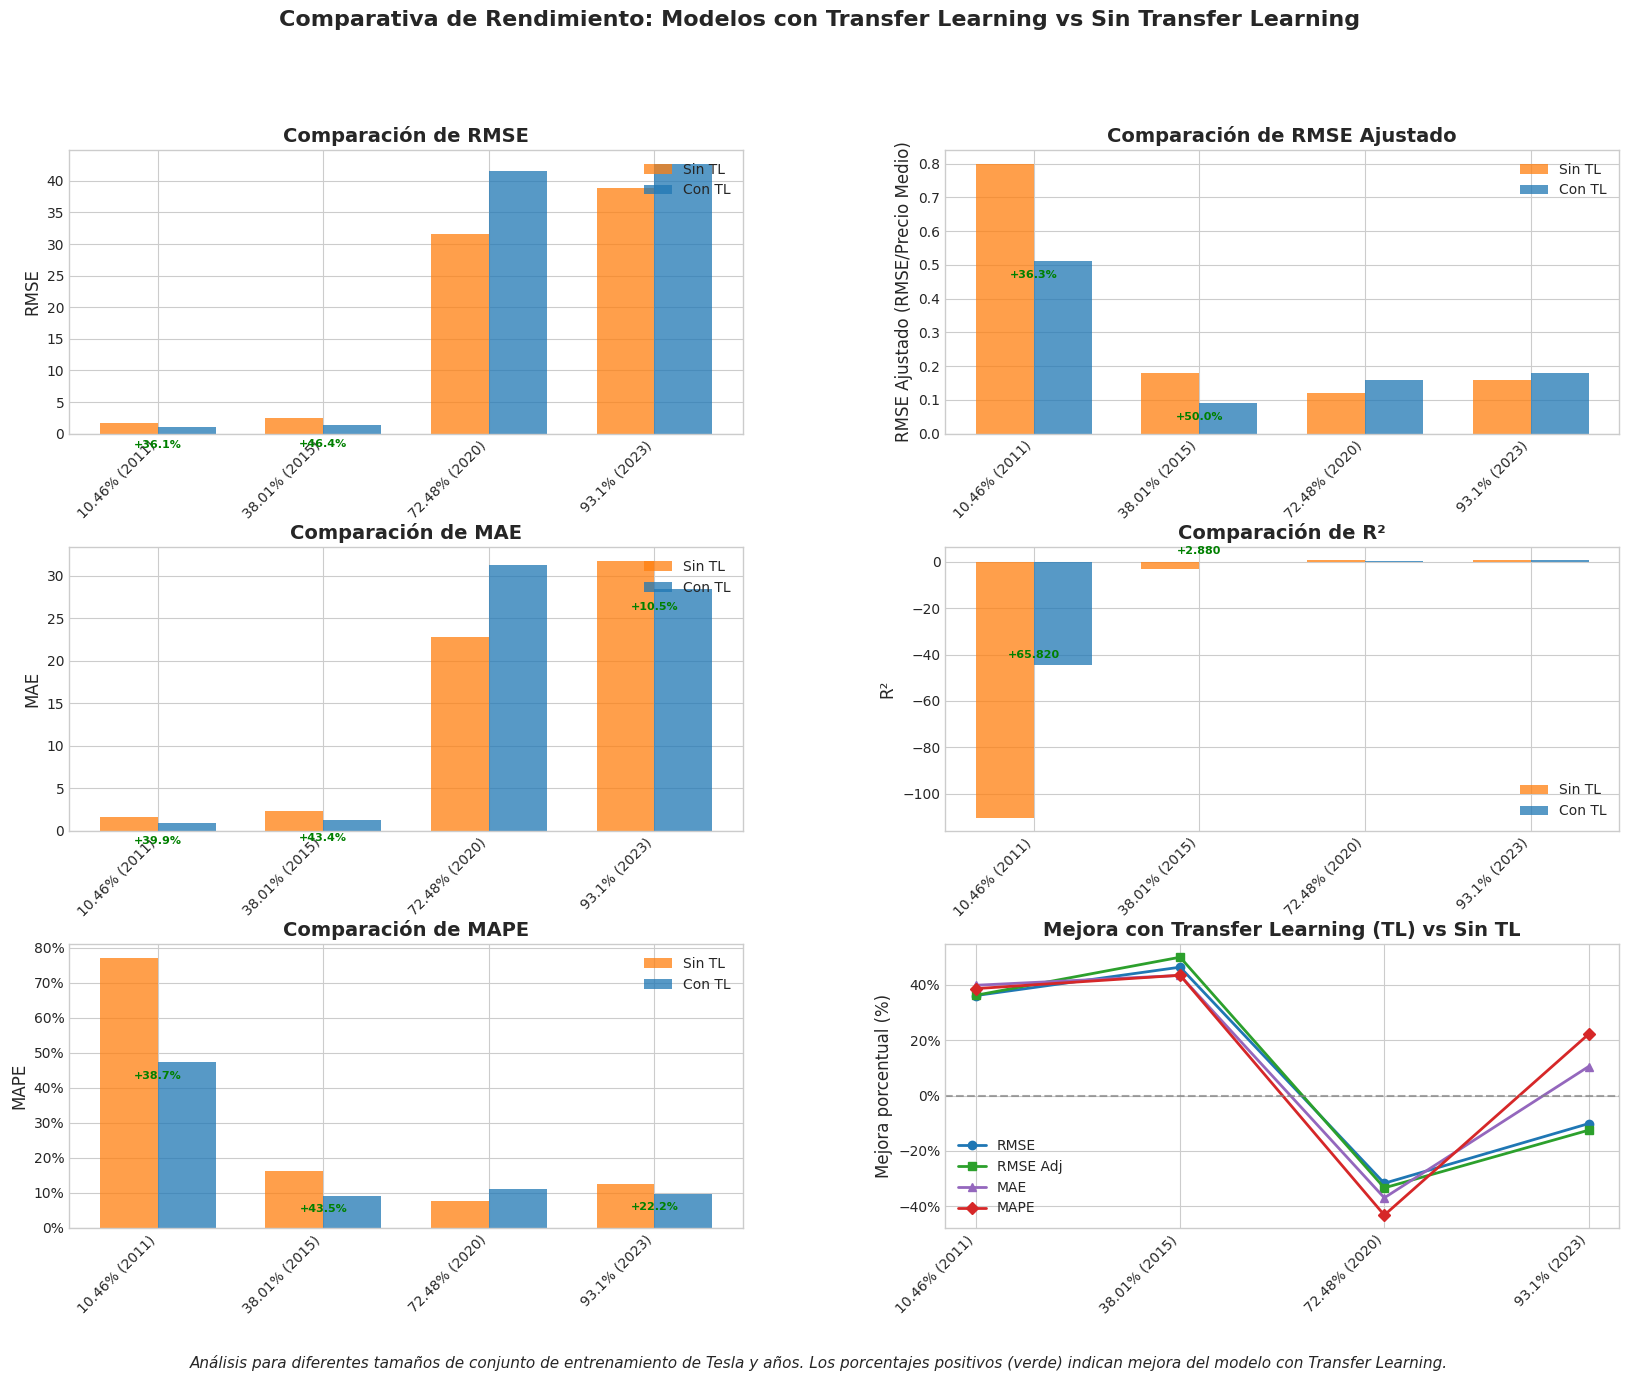

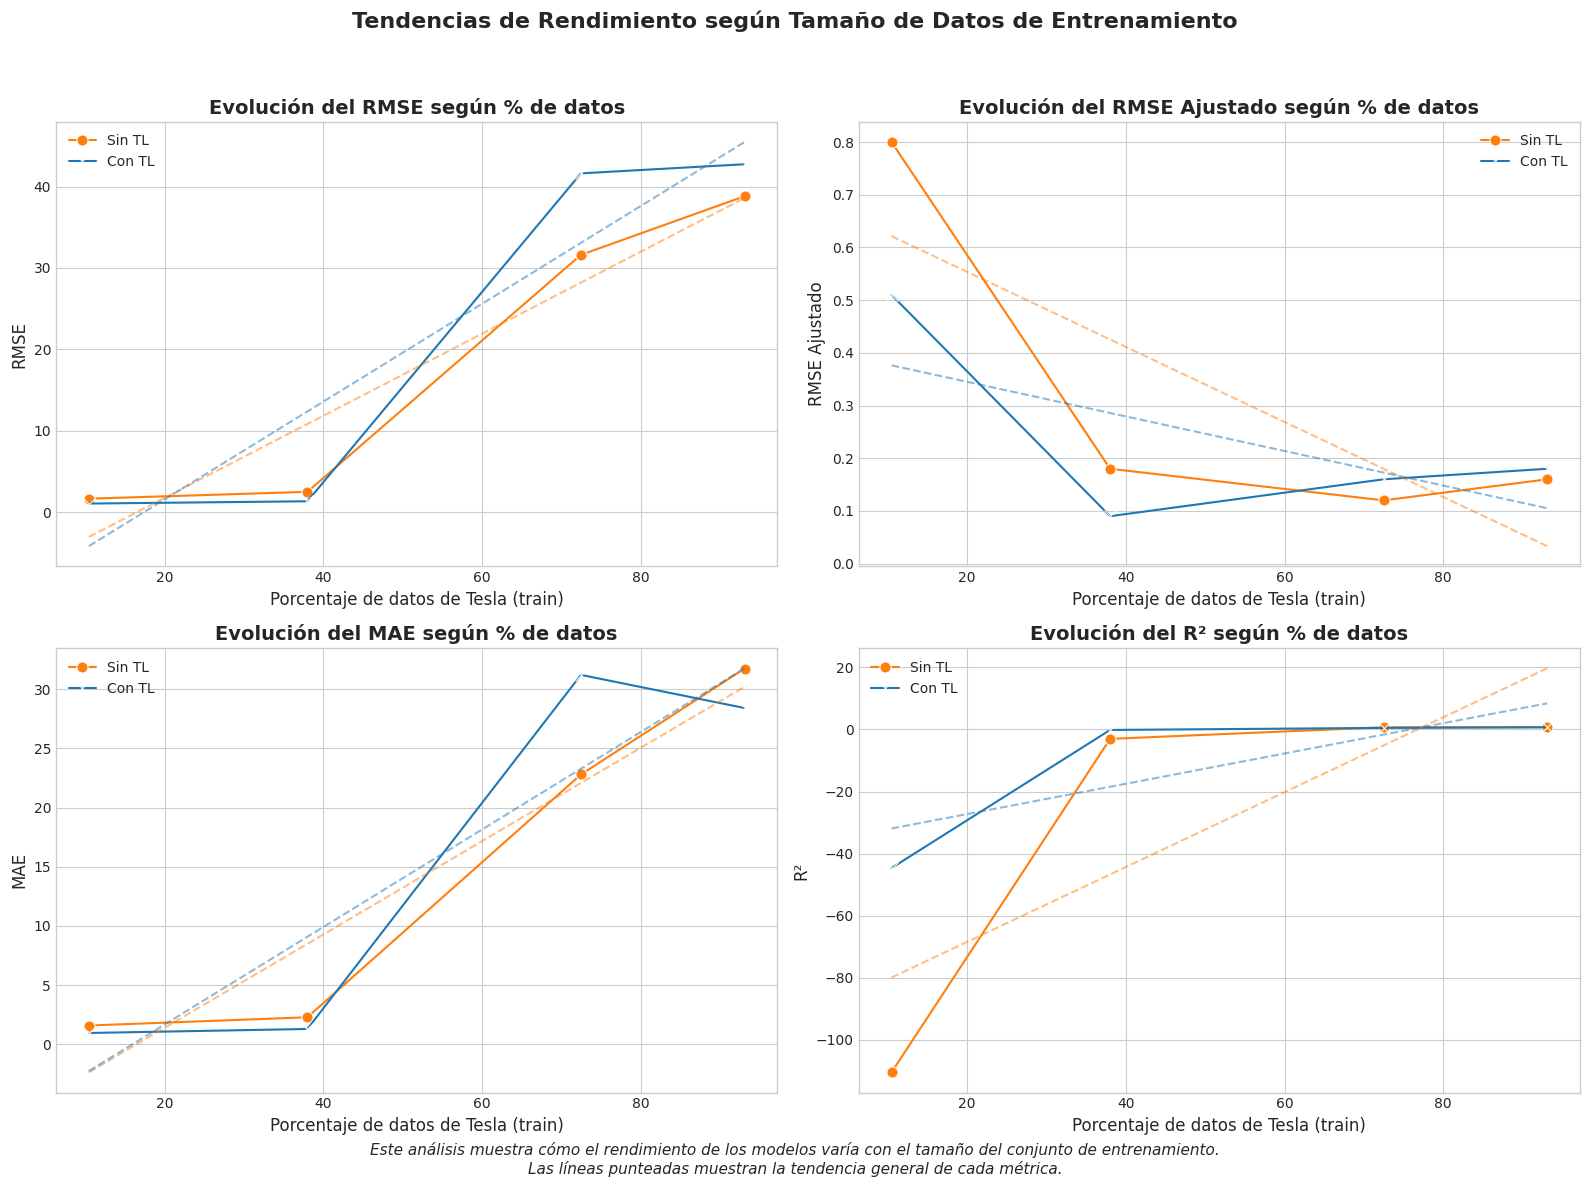

KeyError: "['Mejora R2'] not in index"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick

# Configuración general de estilo
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

def crear_dashboard_comparativo(metricas):
    """Crear dashboard comparativo de todas las métricas relevantes"""

    # Crear figura con subplots en grid - aumentamos el tamaño y ajustamos espaciado
    fig = plt.figure(figsize=(20, 14))
    gs = GridSpec(3, 2, figure=fig, wspace=0.3, hspace=0.4)  # Aumentamos el espaciado

    # Obtener datos para el eje x común
    porcentajes = metricas['Porcentaje Train Tesla'].values

    # Extraer años (asumiendo que están en el índice en formato "Año XXXX+Y")
    years = [idx.split(' ')[1].split('+')[0] for idx in metricas.index]
    etiquetas_x = [f"{pct}% ({yr})" for pct, yr in zip(porcentajes, years)]
    pos_x = np.arange(len(etiquetas_x))

    # 1. Gráfico de RMSE y RMSE Ajustado
    ax1 = fig.add_subplot(gs[0, 0])
    width = 0.35
    ax1.bar(pos_x - width/2, metricas['RMSE Sin TL'], width, label='Sin TL', color='#ff7f0e', alpha=0.75)
    ax1.bar(pos_x + width/2, metricas['RMSE Con TL'], width, label='Con TL', color='#1f77b4', alpha=0.75)

    # Calculamos y mostramos el porcentaje de mejora
    for i in range(len(metricas)):
        mejora = (metricas['RMSE Sin TL'].iloc[i] - metricas['RMSE Con TL'].iloc[i]) / metricas['RMSE Sin TL'].iloc[i] * 100
        if mejora > 0:  # Solo mostrar si hay mejora positiva
            # Ajustamos posición vertical para evitar solapamiento
            ax1.text(i, metricas['RMSE Con TL'].iloc[i] - max(metricas['RMSE Con TL'])*0.05,
                    f"+{mejora:.1f}%", ha='center', va='top', fontsize=8,
                    color='green', fontweight='bold')

    ax1.set_title('Comparación de RMSE', fontweight='bold')
    ax1.set_ylabel('RMSE')
    ax1.set_xticks(pos_x)
    ax1.set_xticklabels(etiquetas_x, rotation=45, ha='right')
    ax1.legend(loc='upper right')  # Especificamos ubicación de leyenda

    # 2. Gráfico de RMSE Ajustado
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.bar(pos_x - width/2, metricas['RMSE Adj. Sin TL'], width, label='Sin TL', color='#ff7f0e', alpha=0.75)
    ax2.bar(pos_x + width/2, metricas['RMSE Adj. Con TL'], width, label='Con TL', color='#1f77b4', alpha=0.75)

    # Mostrar porcentaje de mejora para RMSE Ajustado
    for i in range(len(metricas)):
        mejora = (metricas['RMSE Adj. Sin TL'].iloc[i] - metricas['RMSE Adj. Con TL'].iloc[i]) / metricas['RMSE Adj. Sin TL'].iloc[i] * 100
        if mejora > 0:
            # Ajustamos la posición vertical
            ax2.text(i, metricas['RMSE Adj. Con TL'].iloc[i] - max(metricas['RMSE Adj. Con TL'])*0.05,
                    f"+{mejora:.1f}%", ha='center', va='top', fontsize=8,
                    color='green', fontweight='bold')

    ax2.set_title('Comparación de RMSE Ajustado', fontweight='bold')
    ax2.set_ylabel('RMSE Ajustado (RMSE/Precio Medio)')
    ax2.set_xticks(pos_x)
    ax2.set_xticklabels(etiquetas_x, rotation=45, ha='right')
    ax2.legend(loc='upper right')

    # 3. Gráfico de MAE
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.bar(pos_x - width/2, metricas['MAE Sin TL'], width, label='Sin TL', color='#ff7f0e', alpha=0.75)
    ax3.bar(pos_x + width/2, metricas['MAE Con TL'], width, label='Con TL', color='#1f77b4', alpha=0.75)

    # Mostrar porcentaje de mejora para MAE
    for i in range(len(metricas)):
        mejora = (metricas['MAE Sin TL'].iloc[i] - metricas['MAE Con TL'].iloc[i]) / metricas['MAE Sin TL'].iloc[i] * 100
        if mejora > 0:
            # Ajustamos la posición vertical
            ax3.text(i, metricas['MAE Con TL'].iloc[i] - max(metricas['MAE Con TL'])*0.05,
                    f"+{mejora:.1f}%", ha='center', va='top', fontsize=8,
                    color='green', fontweight='bold')

    ax3.set_title('Comparación de MAE', fontweight='bold')
    ax3.set_ylabel('MAE')
    ax3.set_xticks(pos_x)
    ax3.set_xticklabels(etiquetas_x, rotation=45, ha='right')
    ax3.legend(loc='upper right')

    # 4. Gráfico de R2
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.bar(pos_x - width/2, metricas['R2 Sin TL'], width, label='Sin TL', color='#ff7f0e', alpha=0.75)
    ax4.bar(pos_x + width/2, metricas['R2 Con TL'], width, label='Con TL', color='#1f77b4', alpha=0.75)

    # Mostrar porcentaje de mejora para R2
    for i in range(len(metricas)):
        mejora = (metricas['R2 Con TL'].iloc[i] - metricas['R2 Sin TL'].iloc[i])
        if mejora > 0:
            # Ajustamos posición vertical para mejoras pequeñas
            ax4.text(i, metricas['R2 Con TL'].iloc[i] + (ax4.get_ylim()[1] - ax4.get_ylim()[0])*0.02,
                    f"+{mejora:.3f}", ha='center', va='bottom', fontsize=8,
                    color='green', fontweight='bold')

    ax4.set_title('Comparación de R²', fontweight='bold')
    ax4.set_ylabel('R²')
    ax4.set_xticks(pos_x)
    ax4.set_xticklabels(etiquetas_x, rotation=45, ha='right')
    ax4.legend(loc='lower right')  # R2 suele tener mejor aspecto con leyenda abajo

    # 5. Gráfico de MAPE
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.bar(pos_x - width/2, metricas['MAPE Sin TL'], width, label='Sin TL', color='#ff7f0e', alpha=0.75)
    ax5.bar(pos_x + width/2, metricas['MAPE Con TL'], width, label='Con TL', color='#1f77b4', alpha=0.75)

    # Convertir MAPE a porcentaje en el eje y
    ax5.yaxis.set_major_formatter(mtick.PercentFormatter())

    # Mostrar porcentaje de mejora para MAPE
    for i in range(len(metricas)):
        mejora = (metricas['MAPE Sin TL'].iloc[i] - metricas['MAPE Con TL'].iloc[i]) / metricas['MAPE Sin TL'].iloc[i] * 100
        if mejora > 0:
            # Ajustamos la posición vertical
            ax5.text(i, metricas['MAPE Con TL'].iloc[i] - max(metricas['MAPE Con TL'])*0.05,
                    f"+{mejora:.1f}%", ha='center', va='top', fontsize=8,
                    color='green', fontweight='bold')

    ax5.set_title('Comparación de MAPE', fontweight='bold')
    ax5.set_ylabel('MAPE')
    ax5.set_xticks(pos_x)
    ax5.set_xticklabels(etiquetas_x, rotation=45, ha='right')
    ax5.legend(loc='upper right')

    # 6. Gráfico comparativo de tendencias
    ax6 = fig.add_subplot(gs[2, 1])

    # Calcular la mejora porcentual para todas las métricas
    metricas['Mejora RMSE'] = (metricas['RMSE Sin TL'] - metricas['RMSE Con TL']) / metricas['RMSE Sin TL'] * 100
    metricas['Mejora RMSE Adj'] = (metricas['RMSE Adj. Sin TL'] - metricas['RMSE Adj. Con TL']) / metricas['RMSE Adj. Sin TL'] * 100
    metricas['Mejora MAE'] = (metricas['MAE Sin TL'] - metricas['MAE Con TL']) / metricas['MAE Sin TL'] * 100
    metricas['Mejora MAPE'] = (metricas['MAPE Sin TL'] - metricas['MAPE Con TL']) / metricas['MAPE Sin TL'] * 100

    # Graficar líneas de mejora con marcadores más pequeños
    ax6.plot(pos_x, metricas['Mejora RMSE'], 'o-', label='RMSE', linewidth=2, color='#1f77b4', markersize=6)
    ax6.plot(pos_x, metricas['Mejora RMSE Adj'], 's-', label='RMSE Adj', linewidth=2, color='#2ca02c', markersize=6)
    ax6.plot(pos_x, metricas['Mejora MAE'], '^-', label='MAE', linewidth=2, color='#9467bd', markersize=6)
    ax6.plot(pos_x, metricas['Mejora MAPE'], 'D-', label='MAPE', linewidth=2, color='#d62728', markersize=6)

    # Añadir línea horizontal en y=0
    ax6.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

    # Formatear el eje y como porcentaje
    ax6.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax6.set_title('Mejora con Transfer Learning (TL) vs Sin TL', fontweight='bold')
    ax6.set_ylabel('Mejora porcentual (%)')
    ax6.set_xticks(pos_x)
    ax6.set_xticklabels(etiquetas_x, rotation=45, ha='right')
    ax6.legend(loc='best')  # Ubicación automática para este gráfico

    # Añadir título general a la figura
    fig.suptitle('Comparativa de Rendimiento: Modelos con Transfer Learning vs Sin Transfer Learning',
                fontsize=16, fontweight='bold', y=0.98)

    # Añadir texto explicativo en la parte inferior - ajustamos posición
    fig.text(0.5, 0.01,
             "Análisis para diferentes tamaños de conjunto de entrenamiento de Tesla y años. "+
             "Los porcentajes positivos (verde) indican mejora del modelo con Transfer Learning.",
             ha='center', fontsize=11, style='italic')

    # Ajustar automáticamente los espacios entre subplots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    return fig

# 2. Gráfico de evolución de rendimiento respecto al tamaño de entrenamiento
def crear_tendencia_size_effect(metricas):
    """Crear gráfico de evolución de métricas respecto al tamaño de entrenamiento"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    # Ordenar métricas por el porcentaje de datos de entrenamiento
    metricas_sorted = metricas.sort_values('Porcentaje Train Tesla')

    # Crear gráficos para cada métrica
    sns.lineplot(x='Porcentaje Train Tesla', y='RMSE Sin TL', data=metricas_sorted,
                 marker='o', markersize=8, color='#ff7f0e', label='Sin TL', ax=axes[0])
    sns.lineplot(x='Porcentaje Train Tesla', y='RMSE Con TL', data=metricas_sorted,
                 marker='x', markersize=8, color='#1f77b4', label='Con TL', ax=axes[0])
    axes[0].set_title('Evolución del RMSE según % de datos', fontweight='bold')
    axes[0].set_xlabel('Porcentaje de datos de Tesla (train)')
    axes[0].set_ylabel('RMSE')

    sns.lineplot(x='Porcentaje Train Tesla', y='RMSE Adj. Sin TL', data=metricas_sorted,
                 marker='o', markersize=8, color='#ff7f0e', label='Sin TL', ax=axes[1])
    sns.lineplot(x='Porcentaje Train Tesla', y='RMSE Adj. Con TL', data=metricas_sorted,
                 marker='x', markersize=8, color='#1f77b4', label='Con TL', ax=axes[1])
    axes[1].set_title('Evolución del RMSE Ajustado según % de datos', fontweight='bold')
    axes[1].set_xlabel('Porcentaje de datos de Tesla (train)')
    axes[1].set_ylabel('RMSE Ajustado')

    sns.lineplot(x='Porcentaje Train Tesla', y='MAE Sin TL', data=metricas_sorted,
                 marker='o', markersize=8, color='#ff7f0e', label='Sin TL', ax=axes[2])
    sns.lineplot(x='Porcentaje Train Tesla', y='MAE Con TL', data=metricas_sorted,
                 marker='x', markersize=8, color='#1f77b4', label='Con TL', ax=axes[2])
    axes[2].set_title('Evolución del MAE según % de datos', fontweight='bold')
    axes[2].set_xlabel('Porcentaje de datos de Tesla (train)')
    axes[2].set_ylabel('MAE')

    sns.lineplot(x='Porcentaje Train Tesla', y='R2 Sin TL', data=metricas_sorted,
                 marker='o', markersize=8, color='#ff7f0e', label='Sin TL', ax=axes[3])
    sns.lineplot(x='Porcentaje Train Tesla', y='R2 Con TL', data=metricas_sorted,
                 marker='x', markersize=8, color='#1f77b4', label='Con TL', ax=axes[3])
    axes[3].set_title('Evolución del R² según % de datos', fontweight='bold')
    axes[3].set_xlabel('Porcentaje de datos de Tesla (train)')
    axes[3].set_ylabel('R²')

    # Añadir líneas de mejor ajuste
    for ax in axes:
        if ax in [axes[0], axes[1], axes[2]]:  # Para RMSE, RMSE Adj y MAE (menor es mejor)
            # Para el modelo sin TL
            x = metricas_sorted['Porcentaje Train Tesla'].values
            y1 = ax.get_lines()[0].get_ydata()  # Sin TL
            y2 = ax.get_lines()[1].get_ydata()  # Con TL

            # Ajustar líneas de tendencia
            z1 = np.polyfit(x, y1, 1)
            p1 = np.poly1d(z1)
            ax.plot(x, p1(x), '--', color='#ff7f0e', alpha=0.5)

            z2 = np.polyfit(x, y2, 1)
            p2 = np.poly1d(z2)
            ax.plot(x, p2(x), '--', color='#1f77b4', alpha=0.5)

        else:  # Para R² (mayor es mejor)
            x = metricas_sorted['Porcentaje Train Tesla'].values
            y1 = ax.get_lines()[0].get_ydata()
            y2 = ax.get_lines()[1].get_ydata()

            z1 = np.polyfit(x, y1, 1)
            p1 = np.poly1d(z1)
            ax.plot(x, p1(x), '--', color='#ff7f0e', alpha=0.5)

            z2 = np.polyfit(x, y2, 1)
            p2 = np.poly1d(z2)
            ax.plot(x, p2(x), '--', color='#1f77b4', alpha=0.5)

    # Título general y texto explicativo
    fig.suptitle('Tendencias de Rendimiento según Tamaño de Datos de Entrenamiento',
                fontsize=16, fontweight='bold', y=0.98)

    fig.text(0.5, 0.01,
             "Este análisis muestra cómo el rendimiento de los modelos varía con el tamaño del conjunto de entrenamiento.\n"+
             "Las líneas punteadas muestran la tendencia general de cada métrica.",
             ha='center', fontsize=11, style='italic')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    return fig

# 3. Heatmap de mejora de Transfer Learning
def crear_heatmap_mejora(metricas):
    """Crear heatmap para visualizar la mejora porcentual por métrica y tamaño de entrenamiento"""

    # Calcular las mejoras si no están ya calculadas
    if 'Mejora RMSE' not in metricas.columns:
        metricas['Mejora RMSE'] = (metricas['RMSE Sin TL'] - metricas['RMSE Con TL']) / metricas['RMSE Sin TL'] * 100
        metricas['Mejora RMSE Adj'] = (metricas['RMSE Adj. Sin TL'] - metricas['RMSE Adj. Con TL']) / metricas['RMSE Adj. Sin TL'] * 100
        metricas['Mejora MAE'] = (metricas['MAE Sin TL'] - metricas['MAE Con TL']) / metricas['MAE Sin TL'] * 100
        metricas['Mejora MAPE'] = (metricas['MAPE Sin TL'] - metricas['MAPE Con TL']) / metricas['MAPE Sin TL'] * 100
        metricas['Mejora R2'] = (metricas['R2 Con TL'] - metricas['R2 Sin TL']) * 100  # Cambio en unidades porcentuales

    # Preparar datos para el heatmap
    mejoras = metricas[['Porcentaje Train Tesla', 'Mejora RMSE', 'Mejora RMSE Adj', 'Mejora MAE', 'Mejora MAPE', 'Mejora R2']]

    # Reorganizar los datos para el heatmap usando pivot
    # Extraer años (asumiendo que están en el índice en formato "Año XXXX+Y")
    metricas['Año'] = [idx.split(' ')[1].split('+')[0] for idx in metricas.index]

    # Crear pivotes para cada métrica
    pivot_rmse = metricas.pivot(index='Año', columns='Porcentaje Train Tesla', values='Mejora RMSE')
    pivot_rmse_adj = metricas.pivot(index='Año', columns='Porcentaje Train Tesla', values='Mejora RMSE Adj')
    pivot_mae = metricas.pivot(index='Año', columns='Porcentaje Train Tesla', values='Mejora MAE')
    pivot_mape = metricas.pivot(index='Año', columns='Porcentaje Train Tesla', values='Mejora MAPE')
    pivot_r2 = metricas.pivot(index='Año', columns='Porcentaje Train Tesla', values='Mejora R2')

    # Crear figura para los heatmaps
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Función para añadir anotaciones en cada celda
    def annotate_heatmap(ax, data, cmap):
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                value = data.iloc[i, j]
                if not pd.isna(value):
                    color = 'white' if abs(value) > 25 else 'black'
                    ax.text(j, i, f"{value:.1f}%", ha='center', va='center', color=color, fontweight='bold')

    # Definir un colormap personalizado (azul para mejoras, rojo para empeoramiento)
    cmap = sns.diverging_palette(240, 10, as_cmap=True, center="light")

    # Crear heatmaps
    sns.heatmap(pivot_rmse, annot=False, cmap=cmap, ax=axes[0], vmin=-50, vmax=50, center=0, cbar_kws={'label': 'Mejora %'})
    annotate_heatmap(axes[0], pivot_rmse, cmap)
    axes[0].set_title('Mejora en RMSE (%)', fontweight='bold')
    axes[0].set_xlabel('Porcentaje de Datos de Entrenamiento Tesla')
    axes[0].set_ylabel('Año')

    sns.heatmap(pivot_rmse_adj, annot=False, cmap=cmap, ax=axes[1], vmin=-50, vmax=50, center=0, cbar_kws={'label': 'Mejora %'})
    annotate_heatmap(axes[1], pivot_rmse_adj, cmap)
    axes[1].set_title('Mejora en RMSE Ajustado (%)', fontweight='bold')
    axes[1].set_xlabel('Porcentaje de Datos de Entrenamiento Tesla')
    axes[1].set_ylabel('Año')

    sns.heatmap(pivot_mae, annot=False, cmap=cmap, ax=axes[2], vmin=-50, vmax=50, center=0, cbar_kws={'label': 'Mejora %'})
    annotate_heatmap(axes[2], pivot_mae, cmap)
    axes[2].set_title('Mejora en MAE (%)', fontweight='bold')
    axes[2].set_xlabel('Porcentaje de Datos de Entrenamiento Tesla')
    axes[2].set_ylabel('Año')

    sns.heatmap(pivot_mape, annot=False, cmap=cmap, ax=axes[3], vmin=-50, vmax=50, center=0, cbar_kws={'label': 'Mejora %'})
    annotate_heatmap(axes[3], pivot_mape, cmap)
    axes[3].set_title('Mejora en MAPE (%)', fontweight='bold')
    axes[3].set_xlabel('Porcentaje de Datos de Entrenamiento Tesla')
    axes[3].set_ylabel('Año')

    sns.heatmap(pivot_r2, annot=False, cmap=cmap, ax=axes[4], vmin=-20, vmax=20, center=0, cbar_kws={'label': 'Mejora (puntos porcentuales)'})
    annotate_heatmap(axes[4], pivot_r2, cmap)
    axes[4].set_title('Mejora en R² (puntos porcentuales)', fontweight='bold')
    axes[4].set_xlabel('Porcentaje de Datos de Entrenamiento Tesla')
    axes[4].set_ylabel('Año')

    # Ocultar el último subplot vacío
    axes[5].axis('off')

    # Añadir leyenda de interpretación
    legend_text = """
    Interpretación:
    • Valores positivos (azul): Transfer Learning mejora el rendimiento
    • Valores negativos (rojo): Transfer Learning empeora el rendimiento
    • Intensidad del color: Magnitud de la mejora/empeoramiento
    """
    axes[5].text(0.1, 0.5, legend_text, fontsize=12, va='center')

    # Título general
    fig.suptitle('Mapa de Calor de Mejora con Transfer Learning por Año y Tamaño de Entrenamiento',
                fontsize=16, fontweight='bold', y=0.95)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    return fig

# 4. Radar chart para comparar rendimiento global
def crear_radar_chart(metricas):
    """Crear un radar chart para comparar rendimiento global de modelos con y sin TL"""

    # Calcular métricas promedio
    mean_metrics = pd.DataFrame({
        'Sin TL': [
            metricas['RMSE Sin TL'].mean(),
            metricas['RMSE Adj. Sin TL'].mean(),
            metricas['MAE Sin TL'].mean(),
            metricas['MAPE Sin TL'].mean(),
            1 - metricas['R2 Sin TL'].mean()  # Invertimos R² para que valores más bajos sean mejores
        ],
        'Con TL': [
            metricas['RMSE Con TL'].mean(),
            metricas['RMSE Adj. Con TL'].mean(),
            metricas['MAE Con TL'].mean(),
            metricas['MAPE Con TL'].mean(),
            1 - metricas['R2 Con TL'].mean()  # Invertimos R² para que valores más bajos sean mejores
        ]
    }, index=['RMSE', 'RMSE Adj', 'MAE', 'MAPE', '1-R²'])

    # Normalizar datos para el radar chart (escala 0-1, donde 0 es mejor)
    normalized = mean_metrics.copy()
    for i in normalized.index:
        max_val = normalized.loc[i].max()
        min_val = normalized.loc[i].min()
        if max_val != min_val:  # Evitar división por cero
            normalized.loc[i] = (normalized.loc[i] - min_val) / (max_val - min_val)
        else:
            normalized.loc[i] = 0

    # Crear figura para el radar chart
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)

    # Número de variables
    categories = normalized.index
    N = len(categories)

    # Ángulos para cada eje
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Cerrar el polígono

    # Preparar datos para graficar
    values_sin_tl = normalized['Sin TL'].values.tolist()
    values_sin_tl += values_sin_tl[:1]  # Cerrar el polígono

    values_con_tl = normalized['Con TL'].values.tolist()
    values_con_tl += values_con_tl[:1]  # Cerrar el polígono

    # Graficar líneas
    ax.plot(angles, values_sin_tl, 'o-', linewidth=2, label='Sin Transfer Learning', color='#ff7f0e')
    ax.fill(angles, values_sin_tl, alpha=0.1, color='#ff7f0e')

    ax.plot(angles, values_con_tl, 'o-', linewidth=2, label='Con Transfer Learning', color='#1f77b4')
    ax.fill(angles, values_con_tl, alpha=0.1, color='#1f77b4')

    # Añadir etiquetas
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)

    # Añadir leyenda y título
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax.set_title('Comparativa Global de Rendimiento\n(valores más cercanos al centro son mejores)',
                fontweight='bold', size=15, y=1.08)

    # Invertir escala para que el centro sea mejor
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.5, 0.75])
    ax.set_yticklabels(['Excelente', 'Bueno', 'Regular'])

    # Añadir grid
    ax.grid(True, linestyle='--', alpha=0.7)

    return fig

# 5. Análisis de la relación entre el tamaño de entrenamiento y la mejora
def crear_scatter_mejora_tamano(metricas):
    """Crear gráfico de dispersión para analizar relación entre tamaño y mejora"""

    # Calcular mejoras si no están calculadas
    if 'Mejora RMSE' not in metricas.columns:
        metricas['Mejora RMSE'] = (metricas['RMSE Sin TL'] - metricas['RMSE Con TL']) / metricas['RMSE Sin TL'] * 100
        metricas['Mejora RMSE Adj'] = (metricas['RMSE Adj. Sin TL'] - metricas['RMSE Adj. Con TL']) / metricas['RMSE Adj. Sin TL'] * 100
        metricas['Mejora MAE'] = (metricas['MAE Sin TL'] - metricas['MAE Con TL']) / metricas['MAE Sin TL'] * 100
        metricas['Mejora MAPE'] = (metricas['MAPE Sin TL'] - metricas['MAPE Con TL']) / metricas['MAPE Sin TL'] * 100
        metricas['Mejora R2'] = (metricas['R2 Con TL'] - metricas['R2 Sin TL']) * 100  # puntos porcentuales

    # Extraer años (asumiendo que están en el índice en formato "Año XXXX+Y")
    if 'Año' not in metricas.columns:
        metricas['Año'] = [idx.split(' ')[1].split('+')[0] for idx in metricas.index]

    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 8))

    # Crear scatter plot
    scatter = ax.scatter(metricas['Porcentaje Train Tesla'], metricas['Mejora RMSE'],
                         c=metricas['Año'].astype(int), cmap='viridis',
                         s=100, alpha=0.7, edgecolors='black')

    # Añadir etiquetas para cada punto
    for i, row in metricas.iterrows():
        ax.annotate(f"{row['Año']}",
                    (row['Porcentaje Train Tesla'], row['Mejora RMSE']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold')

    # Añadir línea de regresión
    x = metricas['Porcentaje Train Tesla'].values
    y = metricas['Mejora RMSE'].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.8, label=f"Tendencia: y = {z[0]:.2f}x + {z[1]:.2f}")

    # Añadir línea horizontal en y=0
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

    # Añadir colorbar para años
    cbar = plt.colorbar(scatter)
    cbar.set_label('Año')

    # Formatear eje y como porcentaje
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    # Añadir títulos y etiquetas
    ax.set_title('Relación entre Tamaño de Datos de Entrenamiento y Mejora con Transfer Learning',
                fontweight='bold', size=14)
    ax.set_xlabel('Porcentaje de Datos de Entrenamiento Tesla', fontsize=12)
    ax.set_ylabel('Mejora en RMSE (%)', fontsize=12)
    ax.legend()

    # Añadir líneas de cuadrante para facilitar interpretación
    ax.axvspan(0, 50, 0, 0.5, alpha=0.1, color='green')
    ax.axvspan(50, 100, 0, 0.5, alpha=0.1, color='blue')

    # Añadir grid
    ax.grid(True, linestyle='--', alpha=0.3)

    # Añadir texto explicativo
    plt.figtext(0.5, 0.01,
               "Este gráfico muestra la relación entre el tamaño del conjunto de entrenamiento y la mejora lograda con Transfer Learning.\n"+
               "Valores positivos indican que el modelo con TL supera al modelo sin TL. La línea punteada muestra la tendencia general.",
               ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.7, "pad":5})

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    return fig

# 6. Gráfico 3D para analizar la relación entre año, tamaño y mejora
def crear_grafico_3d(metricas):
    """Crear gráfico 3D para visualizar la relación entre año, tamaño de datos y mejora"""

    # Calcular mejoras si no están calculadas
    if 'Mejora RMSE' not in metricas.columns:
        metricas['Mejora RMSE'] = (metricas['RMSE Sin TL'] - metricas['RMSE Con TL']) / metricas['RMSE Sin TL'] * 100

    # Extraer años si no están extraídos
    if 'Año' not in metricas.columns:
        metricas['Año'] = [int(idx.split(' ')[1].split('+')[0]) for idx in metricas.index]
    else:
        metricas['Año'] = metricas['Año'].astype(int)

    # Crear figura 3D
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Crear scatter 3D
    scatter = ax.scatter(metricas['Porcentaje Train Tesla'],
                         metricas['Año'],
                         metricas['Mejora RMSE'],
                         c=metricas['Mejora RMSE'],
                         cmap='coolwarm',
                         s=100,
                         alpha=0.8)

    # Añadir leyenda de color
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Mejora en RMSE (%)')

    # Añadir etiquetas para cada punto
    for i, row in metricas.iterrows():
        ax.text(row['Porcentaje Train Tesla'], row['Año'], row['Mejora RMSE'],
                f"{row['Porcentaje Train Tesla']}%, {row['Año']}",
                fontsize=8)

    # Añadir plano de referencia en z=0
    x_min, x_max = metricas['Porcentaje Train Tesla'].min(), metricas['Porcentaje Train Tesla'].max()
    y_min, y_max = metricas['Año'].min(), metricas['Año'].max()

    x_plane = np.linspace(x_min - 5, x_max + 5, 10)
    y_plane = np.linspace(y_min - 1, y_max + 1, 10)
    X, Y = np.meshgrid(x_plane, y_plane)
    Z = np.zeros(X.shape)

    ax.plot_surface(X, Y, Z, alpha=0.1, color='gray')

    # Añadir títulos y etiquetas
    ax.set_title('Análisis 3D: Relación entre Año, Tamaño de Datos y Mejora con Transfer Learning',
                fontweight='bold', size=14)
    ax.set_xlabel('Porcentaje de Datos de Entrenamiento Tesla')
    ax.set_ylabel('Año')
    ax.set_zlabel('Mejora en RMSE (%)')

    # Ajustar perspectiva
    ax.view_init(elev=30, azim=45)

    # Añadir grid
    ax.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()

    return fig

# 7. Resumen estadístico de resultados
def crear_tabla_resumen(metricas):
    """Crear una visualización tabular con resumen estadístico de resultados"""

    # Calcular mejoras si no están calculadas
    if 'Mejora RMSE' not in metricas.columns:
        metricas['Mejora RMSE'] = (metricas['RMSE Sin TL'] - metricas['RMSE Con TL']) / metricas['RMSE Sin TL'] * 100
        metricas['Mejora RMSE Adj'] = (metricas['RMSE Adj. Sin TL'] - metricas['RMSE Adj. Con TL']) / metricas['RMSE Adj. Sin TL'] * 100
        metricas['Mejora MAE'] = (metricas['MAE Sin TL'] - metricas['MAE Con TL']) / metricas['MAE Sin TL'] * 100
        metricas['Mejora MAPE'] = (metricas['MAPE Sin TL'] - metricas['MAPE Con TL']) / metricas['MAPE Sin TL'] * 100
        metricas['Mejora R2'] = (metricas['R2 Con TL'] - metricas['R2 Sin TL']) * 100  # puntos porcentuales

    # Crear figura
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')

    # Calcular estadísticas de mejora
    stats = pd.DataFrame({
        'Métrica': ['RMSE', 'RMSE Ajustado', 'MAE', 'MAPE', 'R²'],
        'Mejora Media (%)': [
            metricas['Mejora RMSE'].mean(),
            metricas['Mejora RMSE Adj'].mean(),
            metricas['Mejora MAE'].mean(),
            metricas['Mejora MAPE'].mean(),
            metricas['Mejora R2'].mean()
        ],
        'Mejora Mediana (%)': [
            metricas['Mejora RMSE'].median(),
            metricas['Mejora RMSE Adj'].median(),
            metricas['Mejora MAE'].median(),
            metricas['Mejora MAPE'].median(),
            metricas['Mejora R2'].median()
        ],
        'Mejora Máxima (%)': [
            metricas['Mejora RMSE'].max(),
            metricas['Mejora RMSE Adj'].max(),
            metricas['Mejora MAE'].max(),
            metricas['Mejora MAPE'].max(),
            metricas['Mejora R2'].max()
        ],
        'Mejora Mínima (%)': [
            metricas['Mejora RMSE'].min(),
            metricas['Mejora RMSE Adj'].min(),
            metricas['Mejora MAE'].min(),
            metricas['Mejora MAPE'].min(),
            metricas['Mejora R2'].min()
        ],
        'Desviación Estándar (%)': [
            metricas['Mejora RMSE'].std(),
            metricas['Mejora RMSE Adj'].std(),
            metricas['Mejora MAE'].std(),
            metricas['Mejora MAPE'].std(),
            metricas['Mejora R2'].std()
        ],
        '% Casos con Mejora': [
            (metricas['Mejora RMSE'] > 0).mean() * 100,
            (metricas['Mejora RMSE Adj'] > 0).mean() * 100,
            (metricas['Mejora MAE'] > 0).mean() * 100,
            (metricas['Mejora MAPE'] > 0).mean() * 100,
            (metricas['Mejora R2'] > 0).mean() * 100
        ]
    })

    # Redondear todos los valores a 2 decimales
    stats.iloc[:, 1:] = stats.iloc[:, 1:].round(2)

    # Crear tabla
    table = ax.table(cellText=stats.values, colLabels=stats.columns,
                    loc='center', cellLoc='center',
                    colColours=['#f2f2f2'] * len(stats.columns),
                    rowColours=['#e6f3ff'] * len(stats))

    # Ajustar estilo de la tabla
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Colorear celdas según valor (verde para mejoras positivas, rojo para negativas)
    for i in range(1, len(stats.columns)):
        for j in range(len(stats)):
            cell = table[(j+1, i)]
            text = cell.get_text().get_text()

            try:
                value = float(text)
                if i < 6:  # Columnas de estadísticas
                    if value > 0:
                        cell.set_facecolor('#d4f7d4')  # Verde claro
                    elif value < 0:
                        cell.set_facecolor('#f7d4d4')  # Rojo claro
                else:  # Columna de % de casos
                    if value > 50:
                        cell.set_facecolor('#d4f7d4')  # Verde claro
                    else:
                        cell.set_facecolor('#f7d4d4')  # Rojo claro
            except:
                pass

    # Añadir título
    plt.suptitle('Resumen Estadístico de la Mejora con Transfer Learning',
                fontsize=16, fontweight='bold', y=0.98)

    # Añadir nota explicativa
    plt.figtext(0.5, 0.01,
               "Valores positivos indican que el modelo con Transfer Learning supera al modelo sin Transfer Learning.\n"+
               "Para R², la mejora se mide en puntos porcentuales. Para RMSE, RMSE Ajustado, MAE y MAPE, la mejora se mide como reducción porcentual del error.",
               ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.7, "pad":5})

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    return fig

# 8. Análisis de significancia estadística
def crear_analisis_significancia(metricas):
    """Crear visualización para análisis de significancia estadística"""

    from scipy import stats

    # Crear figura
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Realizar pruebas t pareadas para cada métrica
    # RMSE
    t_stat_rmse, p_value_rmse = stats.ttest_rel(metricas['RMSE Sin TL'], metricas['RMSE Con TL'])

    # RMSE Ajustado
    t_stat_rmse_adj, p_value_rmse_adj = stats.ttest_rel(metricas['RMSE Adj. Sin TL'], metricas['RMSE Adj. Con TL'])

    # MAE
    t_stat_mae, p_value_mae = stats.ttest_rel(metricas['MAE Sin TL'], metricas['MAE Con TL'])

    # MAPE
    t_stat_mape, p_value_mape = stats.ttest_rel(metricas['MAPE Sin TL'], metricas['MAPE Con TL'])

    # R2
    t_stat_r2, p_value_r2 = stats.ttest_rel(metricas['R2 Sin TL'], metricas['R2 Con TL'])

    # Crear boxplots para cada métrica
    sns.boxplot(data=pd.DataFrame({
        'Sin TL': metricas['RMSE Sin TL'],
        'Con TL': metricas['RMSE Con TL']
    }), ax=axes[0])
    axes[0].set_title(f'RMSE (p-value: {p_value_rmse:.4f})', fontweight='bold')
    axes[0].set_ylabel('RMSE')

    sns.boxplot(data=pd.DataFrame({
        'Sin TL': metricas['RMSE Adj. Sin TL'],
        'Con TL': metricas['RMSE Adj. Con TL']
    }), ax=axes[1])
    axes[1].set_title(f'RMSE Ajustado (p-value: {p_value_rmse_adj:.4f})', fontweight='bold')
    axes[1].set_ylabel('RMSE Ajustado')

    sns.boxplot(data=pd.DataFrame({
        'Sin TL': metricas['MAE Sin TL'],
        'Con TL': metricas['MAE Con TL']
    }), ax=axes[2])
    axes[2].set_title(f'MAE (p-value: {p_value_mae:.4f})', fontweight='bold')
    axes[2].set_ylabel('MAE')

    sns.boxplot(data=pd.DataFrame({
        'Sin TL': metricas['MAPE Sin TL'],
        'Con TL': metricas['MAPE Con TL']
    }), ax=axes[3])
    axes[3].set_title(f'MAPE (p-value: {p_value_mape:.4f})', fontweight='bold')
    axes[3].set_ylabel('MAPE')

    sns.boxplot(data=pd.DataFrame({
        'Sin TL': metricas['R2 Sin TL'],
        'Con TL': metricas['R2 Con TL']
    }), ax=axes[4])
    axes[4].set_title(f'R² (p-value: {p_value_r2:.4f})', fontweight='bold')
    axes[4].set_ylabel('R²')

    # Interpretar resultados en el último subplot
    axes[5].axis('off')

    # Crear un resumen de significancia
    significance_text = "Análisis de Significancia Estadística:\n\n"

    for metric, p_value in [
        ("RMSE", p_value_rmse),
        ("RMSE Ajustado", p_value_rmse_adj),
        ("MAE", p_value_mae),
        ("MAPE", p_value_mape),
        ("R²", p_value_r2)
    ]:
        significance = "significativa" if p_value < 0.05 else "no significativa"
        significance_text += f"• {metric}: diferencia {significance} (p = {p_value:.4f})\n"

    significance_text += "\nInterpretación:\n"
    significance_text += "• p < 0.05: Hay diferencia estadísticamente significativa\n"
    significance_text += "• p ≥ 0.05: No hay suficiente evidencia de diferencia\n\n"
    significance_text += "Nota: Se utilizó una prueba t pareada con nivel de significancia α = 0.05"

    axes[5].text(0, 0.5, significance_text, fontsize=12, va='center')

    # Título general
    plt.suptitle('Análisis de Significancia Estadística: ¿Es el Transfer Learning Realmente Mejor?',
                fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    return fig

# Función principal que ejecuta todas las visualizaciones
def generar_visualizaciones(metricas):
    """Función principal que ejecuta todas las visualizaciones"""

    # 1. Dashboard comparativo general
    fig1 = crear_dashboard_comparativo(metricas)
    fig1.savefig('dashboard_comparativo.png', dpi=300, bbox_inches='tight')

    # 2. Efecto del tamaño de entrenamiento
    fig2 = crear_tendencia_size_effect(metricas)
    fig2.savefig('tendencia_size_effect.png', dpi=300, bbox_inches='tight')

    # 3. Heatmap de mejora
    fig3 = crear_heatmap_mejora(metricas)
    fig3.savefig('heatmap_mejora.png', dpi=300, bbox_inches='tight')

    # 4. Radar chart
    fig4 = crear_radar_chart(metricas)
    fig4.savefig('radar_chart.png', dpi=300, bbox_inches='tight')

    # 5. Relación entre tamaño y mejora
    fig5 = crear_scatter_mejora_tamano(metricas)
    fig5.savefig('scatter_mejora_tamano.png', dpi=300, bbox_inches='tight')

    # 6. Gráfico 3D
    fig6 = crear_grafico_3d(metricas)
    fig6.savefig('grafico_3d.png', dpi=300, bbox_inches='tight')

    # 7. Tabla resumen estadístico
    fig7 = crear_tabla_resumen(metricas)
    fig7.savefig('tabla_resumen.png', dpi=300, bbox_inches='tight')

    # 8. Análisis de significancia
    fig8 = crear_analisis_significancia(metricas)
    fig8.savefig('analisis_significancia.png', dpi=300, bbox_inches='tight')

    # Devolver todas las figuras
    return [fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8]

# Código para ejecutar todas las visualizaciones:
#figuras = generar_visualizaciones(metricas)
#plt.show()

# También se pueden ejecutar visualizaciones individuales:

fig1 = crear_dashboard_comparativo(metricas)
plt.show()

# 2. Efecto del tamaño de entrenamiento
fig2 = crear_tendencia_size_effect(metricas)
plt.show()

  # 3. Heatmap de mejora
fig3 = crear_heatmap_mejora(metricas)
plt.show()

    # 4. Radar chart
fig4 = crear_radar_chart(metricas)
plt.show()

    # 5. Relación entre tamaño y mejora
fig5 = crear_scatter_mejora_tamano(metricas)
plt.show()

# 6. Gráfico 3D
fig6 = crear_grafico_3d(metricas)
plt.show()

# 7. Tabla resumen estadístico
fig7 = crear_tabla_resumen(metricas)
plt.show()

# 8. Análisis de significancia
fig8 = crear_analisis_significancia(metricas)
plt.show()

